# Appendix A - Supporting Python Code

## 1) Clustering

### 1.1) Loading The Corpus

Let's begin by importing our corpus - the dataset of moview reviews.

In [42]:
# Import relevant packages
import pandas as pd
import os
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import random
from dataclasses import dataclass

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer

import gensim
from gensim import corpora, similarities
from gensim.models import Word2Vec, LdaMulticore, TfidfModel, CoherenceModel
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import LsiModel,LdaModel

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE, MDS
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, RocCurveDisplay
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import scipy.cluster.hierarchy

from IPython.display import display, HTML

from typing import List, Callable, Dict

In [2]:
# Complete NLTK Downloads
# Only run this once, they will be downloaded.
nltk.download('stopwords',quiet=True)
nltk.download('wordnet',quiet=True)
nltk.download('punkt',quiet=True)
nltk.download('omw-1.4',quiet=True)

True

In [3]:
print("Genism Version: ", gensim.__version__)

Genism Version:  4.1.2


In [4]:
# Suppress Warning Messages
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [5]:
# Create corpus dataframe

# Create Document class
@dataclass
class Document:
    doc_id: str
    text: str

def add_movie_descriptor(data: pd.DataFrame, corpus_df: pd.DataFrame):
    """
    Adds "Movie Description" to the supplied dataframe, in the form {Genre}_{P|N}_{Movie Title}_{DocID}
    """
    review = np.where(corpus_df['Review Type (pos or neg)'] == 'Positive', 'P', 'N')
    data['Descriptor'] = corpus_df['Genre of Movie'] + '_' + corpus_df['Movie Title'] + '_' + review + '_' + corpus_df['Doc_ID'].astype(str)

def get_corpus_df(path):
    data = pd.read_csv(path, encoding="utf-8")
    add_movie_descriptor(data, data)
    sorted_data = data.sort_values(['Descriptor'])
    indexed_data = sorted_data.set_index(['Doc_ID'])
    indexed_data['Doc_ID'] = indexed_data.index
    return indexed_data

# Define documents in this new class
corpus_df = get_corpus_df('MSDS453_ClassCorpus_Final_Sec56_v5_20230720.csv')
documents = [Document(x, y) for x, y in zip(corpus_df.Doc_ID, corpus_df.Text)]

### 1.2) Exploratory Data Analysis

Having imported the corpus of movie reviews, let's conduct exploratory data analysis on the raw dataset.

In [6]:
corpus_df.shape

(190, 9)

In [7]:
corpus_df.head(4).T

Doc_ID                                                                  101  \
DSI_Title                                                 SAR_Doc1_Covenant   
Submission File Name                                      SAR_Doc1_Covenant   
Student Name                                                            SAR   
Genre of Movie                                                       Action   
Review Type (pos or neg)                                           Negative   
Movie Title                                                        Covenant   
Text                      Nearly two years after the American military w...   
Descriptor                                            Action_Covenant_N_101   
Doc_ID                                                                  101   

Doc_ID                                                                  102  \
DSI_Title                                                 SAR_Doc2_Covenant   
Submission File Name                                      SAR_Doc2_Covenant   
Student Name                                                            SAR   
Genre of Movie                                                       Action   
Review Type (pos or neg)                                           Negative   
Movie Title                                                        Covenant   
Text                      Have Guy Ritchie and Jake Gyllenhaal switched ...   
Descriptor                                            Action_Covenant_N_102   
Doc_ID                                                                  102   

Doc_ID                                                                  103  \
DSI_Title                                                 SAR_Doc3_Covenant   
Submission File Name                                      SAR_Doc3_Covenant   
Student Name                                                            SAR   
Genre of Movie                                                       Action   
Review Type (pos or neg)                                           Negative   
Movie Title                                                        Covenant   
Text                      Guy Ritchie's The Covenant notably marks the f...   
Descriptor                                            Action_Covenant_N_103   
Doc_ID                                                                  103   

Doc_ID                                                                  104  
DSI_Title                                                 SAR_Doc4_Covenant  
Submission File Name                                      SAR_Doc4_Covenant  
Student Name                                                            SAR  
Genre of Movie                                                       Action  
Review Type (pos or neg)                                           Negative  
Movie Title                                                        Covenant  
Text                      In a weird throwback to those Chuck Norris "Mi...  
Descriptor                                            Action_Covenant_N_104  
Doc_ID                                                                  104

In [8]:
print(corpus_df.info());

<class 'pandas.core.frame.DataFrame'>
Int64Index: 190 entries, 101 to 217
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   DSI_Title                 190 non-null    object
 1   Submission File Name      190 non-null    object
 2   Student Name              190 non-null    object
 3   Genre of Movie            190 non-null    object
 4   Review Type (pos or neg)  190 non-null    object
 5   Movie Title               190 non-null    object
 6   Text                      190 non-null    object
 7   Descriptor                190 non-null    object
 8   Doc_ID                    190 non-null    int64 
dtypes: int64(1), object(8)
memory usage: 14.8+ KB
None


In [9]:
print(corpus_df['Movie Title'].unique())

['Covenant' 'Inception' 'No time to die' 'Taken' 'The Dark Knight Rises'
 'Despicable Me 3' 'Holmes and Watson' 'Legally Blonde' 'Lost City'
 'Sisters' 'Drag Me to Hell' 'Fresh' 'It Chapter Two' 'The Toxic Avenger'
 'US' 'Annihilation' 'Minority Report' 'Oblivion' 'Pitch Black']


In [10]:
# Gather the number of reviews by genre
counts_df = corpus_df[['Genre of Movie']].copy()
counts_df['Count'] = 1
counts_df.groupby(['Genre of Movie']).count().reset_index()

Genre of Movie  Count
0         Action     50
1         Comedy     50
2         Horror     50
3         Sci-Fi     40

In [11]:
corpus_df.columns

Index(['DSI_Title', 'Submission File Name', 'Student Name', 'Genre of Movie',
       'Review Type (pos or neg)', 'Movie Title', 'Text', 'Descriptor',
       'Doc_ID'],
      dtype='object')

### 1.3) Data Wrangling And Vectorization 

#### 1.3.1) Data Wrangling and Vectorization Method 1

Let's implement our first data wrangling and vectorization methodology.  

As specified in the clean_doc_method_one and tfidf functions below, this methodology will consist of:
* Tokenization
* Punctuation Removal
* Removal of Non-Alphabetic Tokens
* Removal of Tokens with 3 or Fewer Characters
* Changing all characters to lowercase
* Removal of Standard English Stop Words
* TF-IDF Vectorization of Documents

The outputs will be stored in the "processed_text_method_one" column of the corpus_df dataframe and in the "processed_text_method_one" list.

In [12]:
def normalize_document(document: Document) -> Document:
    text = document.text
    text = remove_punctuation(text)
    text = lower_case(text)
    text = remove_tags(text)
    text = remove_special_chars_and_digits(text)
    
    return Document(document.doc_id, text)

def normalize_documents(documents: List[Document]) -> List[Document]:
    """
    Normalizes text for all given documents.
    Removes punctuation, converts to lower case, removes tags and special characters.
    """
    return [normalize_document(x) for x in documents]

@dataclass
class TokenizedDocument:
    doc_id: str
    tokens: List[str]

def tokenize_document(document: Document) -> TokenizedDocument:
    tokens = nltk.word_tokenize(document.text)
    return TokenizedDocument(document.doc_id, tokens)

def tokenize_documents(documents: List[Document]) -> List[TokenizedDocument]:
    return [tokenize_document(x) for x in documents]

def lemmatize(documents: List[TokenizedDocument]) -> List[TokenizedDocument]:
    result = []
    lemmatizer = WordNetLemmatizer()
    for document in documents:
        output_tokens = [lemmatizer.lemmatize(w) for w in document.tokens]
        result.append(TokenizedDocument(document.doc_id, output_tokens))
        
    return result

def stem(documents: List[TokenizedDocument]) -> List[TokenizedDocument]:
    result = []
    stemmer = PorterStemmer()
    for document in documents:
        output_tokens = [stemmer.stem(w) for w in document.tokens]
        result.append(TokenizedDocument(document.doc_id, output_tokens))

    return result

def remove_stop_words(documents: List[TokenizedDocument]) -> List[TokenizedDocument]:
    result = []
    
    stop_words = set(nltk.corpus.stopwords.words('english')) 
    for document in documents:
        filtered_tokens = [w for w in document.tokens if not w in stop_words]
        result.append(TokenizedDocument(document.doc_id, filtered_tokens))
        
    return result
    
def add_flags(data: pd.DataFrame, sisters_doc_ids: List[int], comedy_doc_ids: List[int]):
    data['is_sisters'] = data.index.isin(sisters_doc_ids)
    data['is_comedy'] = data.index.isin(comedy_doc_ids)
    
def get_all_tokens(documents: List[TokenizedDocument]) -> List[str]:
    tokens = {y for x in documents for y in x.tokens}
    return sorted(list(tokens))

def clean_doc_method_one(doc): 
    #split document into individual words
    tokens=doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 4]
    #lowercase all words
    tokens = [word.lower() for word in tokens]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]         
    # word stemming    
    # ps=PorterStemmer()
    # tokens=[ps.stem(word) for word in tokens]
    return tokens

def final_processed_text_disabled(doc):
    #this is a function to join the processed text back
    ' '.join(doc)
    return doc

def tfidf(corpus, titles, ngram_range = (1,1)):
    #this is a function to created the tfidf matrix
    Tfidf=TfidfVectorizer(ngram_range=(1,1))

    #fit the vectorizer using final processed documents.  The vectorizer requires the 
    #stiched back together document.

    TFIDF_matrix=Tfidf.fit_transform(corpus)     

    #creating datafram from TFIDF Matrix

    # https://stackoverflow.com/questions/70215049/attributeerror-tfidfvectorizer-object-has-no-attribute-get-feature-names-out
    #words = Tfidf.get_feature_names() # For sklearn <= 0.24.x
    #matrix=pd.DataFrame(TFIDF_matrix.toarray(), columns=Tfidf.get_feature_names(), index=titles)

    words = Tfidf.get_feature_names_out() # For sklearn >= 1.0.x
    matrix=pd.DataFrame(TFIDF_matrix.toarray(), columns=Tfidf.get_feature_names_out(), index=titles)
    return matrix #,words

In [13]:
#adding two columns to the dataframe to store the processed text and tokenized text
corpus_df['processed_text_method_one'] = corpus_df['Text'].apply(lambda x: clean_doc_method_one(x))

#creating final processed text variables for matrix creation
final_processed_text_method_one = [' '.join(x) for x in corpus_df['processed_text_method_one'].tolist()]
titles = corpus_df['DSI_Title'].tolist()
processed_text_method_one = corpus_df['processed_text_method_one'].tolist()

In [15]:
tfidf_matrix_method_one = tfidf(final_processed_text_method_one, titles, ngram_range = (1,1))

In [16]:
tfidf_matrix_method_one

aardman  aaron  abandon  abandoned  abandonment  \
SAR_Doc1_Covenant        0.0    0.0      0.0   0.000000          0.0   
SAR_Doc2_Covenant        0.0    0.0      0.0   0.000000          0.0   
SAR_Doc3_Covenant        0.0    0.0      0.0   0.000000          0.0   
SAR_Doc4_Covenant        0.0    0.0      0.0   0.000000          0.0   
SAR_Doc5_Covenant        0.0    0.0      0.0   0.099853          0.0   
...                      ...    ...      ...        ...          ...   
OSO_Doc3_PitchBlack      0.0    0.0      0.0   0.000000          0.0   
OSO_Doc4_PitchBlack      0.0    0.0      0.0   0.063045          0.0   
OSO_Doc5_PitchBlack      0.0    0.0      0.0   0.057051          0.0   
OSO_Doc6_PitchBlack      0.0    0.0      0.0   0.000000          0.0   
OSO_Doc7_PitchBlack      0.0    0.0      0.0   0.000000          0.0   

                     abandons  abdicate  abdicating  abduct  abducted  ...  \
SAR_Doc1_Covenant         0.0       0.0         0.0     0.0       0.0  ...   
SAR_Doc2_Covenant         0.0       0.0         0.0     0.0       0.0  ...   
SAR_Doc3_Covenant         0.0       0.0         0.0     0.0       0.0  ...   
SAR_Doc4_Covenant         0.0       0.0         0.0     0.0       0.0  ...   
SAR_Doc5_Covenant         0.0       0.0         0.0     0.0       0.0  ...   
...                       ...       ...         ...     ...       ...  ...   
OSO_Doc3_PitchBlack       0.0       0.0         0.0     0.0       0.0  ...   
OSO_Doc4_PitchBlack       0.0       0.0         0.0     0.0       0.0  ...   
OSO_Doc5_PitchBlack       0.0       0.0         0.0     0.0       0.0  ...   
OSO_Doc6_PitchBlack       0.0       0.0         0.0     0.0       0.0  ...   
OSO_Doc7_PitchBlack       0.0       0.0         0.0     0.0       0.0  ...   

                     zimmer  zimmers  zingers  zingy  zippier  zippy  \
SAR_Doc1_Covenant       0.0      0.0      0.0    0.0      0.0    0.0   
SAR_Doc2_Covenant       0.0      0.0      0.0    0.0      0.0    0.0   
SAR_Doc3_Covenant       0.0      0.0      0.0    0.0      0.0    0.0   
SAR_Doc4_Covenant       0.0      0.0      0.0    0.0      0.0    0.0   
SAR_Doc5_Covenant       0.0      0.0      0.0    0.0      0.0    0.0   
...                     ...      ...      ...    ...      ...    ...   
OSO_Doc3_PitchBlack     0.0      0.0      0.0    0.0      0.0    0.0   
OSO_Doc4_PitchBlack     0.0      0.0      0.0    0.0      0.0    0.0   
OSO_Doc5_PitchBlack     0.0      0.0      0.0    0.0      0.0    0.0   
OSO_Doc6_PitchBlack     0.0      0.0      0.0    0.0      0.0    0.0   
OSO_Doc7_PitchBlack     0.0      0.0      0.0    0.0      0.0    0.0   

                     zolfaghari  zombie  zoomy  zzzzs  
SAR_Doc1_Covenant           0.0     0.0    0.0    0.0  
SAR_Doc2_Covenant           0.0     0.0    0.0    0.0  
SAR_Doc3_Covenant           0.0     0.0    0.0    0.0  
SAR_Doc4_Covenant           0.0     0.0    0.0    0.0  
SAR_Doc5_Covenant           0.0     0.0    0.0    0.0  
...                         ...     ...    ...    ...  
OSO_Doc3_PitchBlack         0.0     0.0    0.0    0.0  
OSO_Doc4_PitchBlack         0.0     0.0    0.0    0.0  
OSO_Doc5_PitchBlack         0.0     0.0    0.0    0.0  
OSO_Doc6_PitchBlack         0.0     0.0    0.0    0.0  
OSO_Doc7_PitchBlack         0.0     0.0    0.0    0.0  

[190 rows x 11273 columns]

#### 1.3.2) Data Wrangling and Vectorization Method 2

Now let's apply a second data wrangling and vectorization methodology to our corpus of movie reviews. 

For this methodology, we'll leverage the same data wrangling steps as data wrangling methodology one, but we'll use one hot encoding to vectorize documents instead of tf-idf vectorization.  

In summary, this means that the data wrangling and vectorization steps will be:
* Tokenization
* Punctuation Removal
* Removal of Non-Alphabetic Tokens
* Removal of Tokens with 3 or Fewer Characters
* Changing all characters to lowercase
* Removal of Standard English Stop Words
* One Hot Coding Vectorization of Documents

In [49]:
def One_Hot(variable):
    #this is a function to one hot encode the classes
    LE=LabelEncoder()
    LE.fit(variable)
    Label1=LE.transform(variable)
    OHE=OneHotEncoder()
    labels=OHE.fit_transform(Label1.reshape(-1,1)).toarray()
    return labels
    print(labels)

#adding two columns to the dataframe to store the processed text and tokenized text
corpus_df['processed_text_method_two'] = corpus_df['Text'].apply(lambda x: clean_doc_method_one(x))

#creating final processed text variables for matrix creation
final_processed_text_method_two = [' '.join(x) for x in corpus_df['processed_text_method_two'].tolist()]
titles = corpus_df['DSI_Title'].tolist()
processed_text_method_two = corpus_df['processed_text_method_two'].tolist()

one_hot_array_method_two = One_Hot(final_processed_text_method_two)



In [52]:


one_hot_matrix_method_two = pd.DataFrame(one_hot_array_method_two)

one_hot_matrix_method_two

0    1    2    3    4    5    6    7    8    9    ...  180  181  182  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
185  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
186  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
187  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
188  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
189  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

     183  184  185  186  187  188  189  
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  
..   ...  ...  ...  ...  ...  ...  ...  
185  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
186  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
187  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
188  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
189  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[190 rows x 190 columns]

In [51]:
tfidf_matrix_method_one

aardman  aaron  abandon  abandoned  abandonment  \
SAR_Doc1_Covenant        0.0    0.0      0.0   0.000000          0.0   
SAR_Doc2_Covenant        0.0    0.0      0.0   0.000000          0.0   
SAR_Doc3_Covenant        0.0    0.0      0.0   0.000000          0.0   
SAR_Doc4_Covenant        0.0    0.0      0.0   0.000000          0.0   
SAR_Doc5_Covenant        0.0    0.0      0.0   0.099853          0.0   
...                      ...    ...      ...        ...          ...   
OSO_Doc3_PitchBlack      0.0    0.0      0.0   0.000000          0.0   
OSO_Doc4_PitchBlack      0.0    0.0      0.0   0.063045          0.0   
OSO_Doc5_PitchBlack      0.0    0.0      0.0   0.057051          0.0   
OSO_Doc6_PitchBlack      0.0    0.0      0.0   0.000000          0.0   
OSO_Doc7_PitchBlack      0.0    0.0      0.0   0.000000          0.0   

                     abandons  abdicate  abdicating  abduct  abducted  ...  \
SAR_Doc1_Covenant         0.0       0.0         0.0     0.0       0.0  ...   
SAR_Doc2_Covenant         0.0       0.0         0.0     0.0       0.0  ...   
SAR_Doc3_Covenant         0.0       0.0         0.0     0.0       0.0  ...   
SAR_Doc4_Covenant         0.0       0.0         0.0     0.0       0.0  ...   
SAR_Doc5_Covenant         0.0       0.0         0.0     0.0       0.0  ...   
...                       ...       ...         ...     ...       ...  ...   
OSO_Doc3_PitchBlack       0.0       0.0         0.0     0.0       0.0  ...   
OSO_Doc4_PitchBlack       0.0       0.0         0.0     0.0       0.0  ...   
OSO_Doc5_PitchBlack       0.0       0.0         0.0     0.0       0.0  ...   
OSO_Doc6_PitchBlack       0.0       0.0         0.0     0.0       0.0  ...   
OSO_Doc7_PitchBlack       0.0       0.0         0.0     0.0       0.0  ...   

                     zimmer  zimmers  zingers  zingy  zippier  zippy  \
SAR_Doc1_Covenant       0.0      0.0      0.0    0.0      0.0    0.0   
SAR_Doc2_Covenant       0.0      0.0      0.0    0.0      0.0    0.0   
SAR_Doc3_Covenant       0.0      0.0      0.0    0.0      0.0    0.0   
SAR_Doc4_Covenant       0.0      0.0      0.0    0.0      0.0    0.0   
SAR_Doc5_Covenant       0.0      0.0      0.0    0.0      0.0    0.0   
...                     ...      ...      ...    ...      ...    ...   
OSO_Doc3_PitchBlack     0.0      0.0      0.0    0.0      0.0    0.0   
OSO_Doc4_PitchBlack     0.0      0.0      0.0    0.0      0.0    0.0   
OSO_Doc5_PitchBlack     0.0      0.0      0.0    0.0      0.0    0.0   
OSO_Doc6_PitchBlack     0.0      0.0      0.0    0.0      0.0    0.0   
OSO_Doc7_PitchBlack     0.0      0.0      0.0    0.0      0.0    0.0   

                     zolfaghari  zombie  zoomy  zzzzs  
SAR_Doc1_Covenant           0.0     0.0    0.0    0.0  
SAR_Doc2_Covenant           0.0     0.0    0.0    0.0  
SAR_Doc3_Covenant           0.0     0.0    0.0    0.0  
SAR_Doc4_Covenant           0.0     0.0    0.0    0.0  
SAR_Doc5_Covenant           0.0     0.0    0.0    0.0  
...                         ...     ...    ...    ...  
OSO_Doc3_PitchBlack         0.0     0.0    0.0    0.0  
OSO_Doc4_PitchBlack         0.0     0.0    0.0    0.0  
OSO_Doc5_PitchBlack         0.0     0.0    0.0    0.0  
OSO_Doc6_PitchBlack         0.0     0.0    0.0    0.0  
OSO_Doc7_PitchBlack         0.0     0.0    0.0    0.0  

[190 rows x 11273 columns]

In [50]:
LE=LabelEncoder()
LE.fit(final_processed_text_method_two)
Label1=LE.transform(final_processed_text_method_two)
OHE=OneHotEncoder()
labels=OHE.fit_transform(Label1.reshape(-1,1)).toarray()
print(labels)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


#### 1.3.3) Data Wrangling and Vectorization Method 3

In [ ]:
import textmining

def termdocumentmatrix_example():
    # Create some very short sample documents
    doc1 = 'John and Bob are brothers.'
    doc2 = 'John went to the store. The store was closed.'
    doc3 = 'Bob went to the store too.'
    # Initialize class to create term-document matrix
    tdm = textmining.TermDocumentMatrix()
    # Add the documents
    tdm.add_doc(doc1)
    tdm.add_doc(doc2)
    tdm.add_doc(doc3)
    # Write out the matrix to a csv file. Note that setting cutoff=1 means
    # that words which appear in 1 or more documents will be included in
    # the output (i.e. every word will appear in the output). The default
    # for cutoff is 2, since we usually aren't interested in words which
    # appear in a single document. For this example we want to see all
    # words however, hence cutoff=1.
    tdm.write_csv('matrix.csv', cutoff=1)
    # Instead of writing out the matrix you can also access its rows directly.
    # Let's print them to the screen.
    for row in tdm.rows(cutoff=1):
        print row

#### 1.3.4) Data Wrangling and Vectorization Method 4

We will now implment Data Wrangling and Vectorization Method 4.

This methodology is very similar to method 1, except we also lemmatize the corpus and remove custom stop words.

In summary, these are the steps of this data wrangling and vectorizaiton methodology:
    * Tokenization
* Punctuation Removal
* Removal of Non-Alphabetic Tokens
* Removal of Tokens with 3 or Fewer Characters
* Changing all characters to lowercase
* Removal of Standard English Stop Words
* Lemmatization
* Removal of Custom Stop Words
* TF-IDF Vectorization of Documents

The outputs will be stored in the "processed_text_method_four" column of the corpus_df dataframe and in the "processed_text_method_four" list.

In [61]:
# Define New Function for Data Wrangling
def clean_doc_method_four(doc): 
    #split document into individual words
    tokens=doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 4]
    #lowercase all words
    tokens = [word.lower() for word in tokens]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words] 
    # lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # filter out custom stop words
    custom_stop_words = set(['film', 'movie', 'ha', 'wa', 'get', 'make', 'also', 'much', 'way', 'scene', 'thing', 'would', 'come', 'man', 'say', 'really', 'human', 'audience', 'many', 'made', 'still'  ]) 
    tokens = [w for w in tokens if not w in custom_stop_words] 
    return tokens

In [62]:
#adding two columns to the dataframe to store the processed text and tokenized text
corpus_df['processed_text_method_four'] = corpus_df['Text'].apply(lambda x: clean_doc_method_four(x))

#creating final processed text variables for matrix creation
final_processed_text_method_four = [' '.join(x) for x in corpus_df['processed_text_method_four'].tolist()]



titles = corpus_df['DSI_Title'].tolist()
processed_text_method_four = corpus_df['processed_text_method_four'].tolist()

# Create TF-IDF Matrix
tfidf_matrix_method_four = tfidf(final_processed_text_method_four, titles, ngram_range = (1,1))

tfidf_matrix_method_four

aardman  aaron  abandon  abandoned  abandonment  \
SAR_Doc1_Covenant        0.0    0.0      0.0   0.000000          0.0   
SAR_Doc2_Covenant        0.0    0.0      0.0   0.000000          0.0   
SAR_Doc3_Covenant        0.0    0.0      0.0   0.000000          0.0   
SAR_Doc4_Covenant        0.0    0.0      0.0   0.000000          0.0   
SAR_Doc5_Covenant        0.0    0.0      0.0   0.100975          0.0   
...                      ...    ...      ...        ...          ...   
OSO_Doc3_PitchBlack      0.0    0.0      0.0   0.000000          0.0   
OSO_Doc4_PitchBlack      0.0    0.0      0.0   0.063795          0.0   
OSO_Doc5_PitchBlack      0.0    0.0      0.0   0.058085          0.0   
OSO_Doc6_PitchBlack      0.0    0.0      0.0   0.000000          0.0   
OSO_Doc7_PitchBlack      0.0    0.0      0.0   0.000000          0.0   

                     abdicate  abdicating  abduct  abducted  abduction  ...  \
SAR_Doc1_Covenant         0.0         0.0     0.0       0.0        0.0  ...   
SAR_Doc2_Covenant         0.0         0.0     0.0       0.0        0.0  ...   
SAR_Doc3_Covenant         0.0         0.0     0.0       0.0        0.0  ...   
SAR_Doc4_Covenant         0.0         0.0     0.0       0.0        0.0  ...   
SAR_Doc5_Covenant         0.0         0.0     0.0       0.0        0.0  ...   
...                       ...         ...     ...       ...        ...  ...   
OSO_Doc3_PitchBlack       0.0         0.0     0.0       0.0        0.0  ...   
OSO_Doc4_PitchBlack       0.0         0.0     0.0       0.0        0.0  ...   
OSO_Doc5_PitchBlack       0.0         0.0     0.0       0.0        0.0  ...   
OSO_Doc6_PitchBlack       0.0         0.0     0.0       0.0        0.0  ...   
OSO_Doc7_PitchBlack       0.0         0.0     0.0       0.0        0.0  ...   

                     zero  zimmer  zinger  zingy  zippier  zippy  zolfaghari  \
SAR_Doc1_Covenant     0.0     0.0     0.0    0.0      0.0    0.0         0.0   
SAR_Doc2_Covenant     0.0     0.0     0.0    0.0      0.0    0.0         0.0   
SAR_Doc3_Covenant     0.0     0.0     0.0    0.0      0.0    0.0         0.0   
SAR_Doc4_Covenant     0.0     0.0     0.0    0.0      0.0    0.0         0.0   
SAR_Doc5_Covenant     0.0     0.0     0.0    0.0      0.0    0.0         0.0   
...                   ...     ...     ...    ...      ...    ...         ...   
OSO_Doc3_PitchBlack   0.0     0.0     0.0    0.0      0.0    0.0         0.0   
OSO_Doc4_PitchBlack   0.0     0.0     0.0    0.0      0.0    0.0         0.0   
OSO_Doc5_PitchBlack   0.0     0.0     0.0    0.0      0.0    0.0         0.0   
OSO_Doc6_PitchBlack   0.0     0.0     0.0    0.0      0.0    0.0         0.0   
OSO_Doc7_PitchBlack   0.0     0.0     0.0    0.0      0.0    0.0         0.0   

                     zombie  zoomy  zzzzs  
SAR_Doc1_Covenant       0.0    0.0    0.0  
SAR_Doc2_Covenant       0.0    0.0    0.0  
SAR_Doc3_Covenant       0.0    0.0    0.0  
SAR_Doc4_Covenant       0.0    0.0    0.0  
SAR_Doc5_Covenant       0.0    0.0    0.0  
...                     ...    ...    ...  
OSO_Doc3_PitchBlack     0.0    0.0    0.0  
OSO_Doc4_PitchBlack     0.0    0.0    0.0  
OSO_Doc5_PitchBlack     0.0    0.0    0.0  
OSO_Doc6_PitchBlack     0.0    0.0    0.0  
OSO_Doc7_PitchBlack     0.0    0.0    0.0  

[190 rows x 10397 columns]

### 1.4) Clustering Experiments

#### 1.4.1) K-Means Clustering Experiments

##### Data Wrangling and Vectorization Method 1

Let's conduct our first clustering experiments via K-Means Clustering to determine whether we can successfully cluster movie reviews based on review type, genre, or movie title.

For n_clusters = 2 The average silhouette_score is : 0.008285619416885338
For n_clusters = 3 The average silhouette_score is : 0.00988616929557615
For n_clusters = 4 The average silhouette_score is : 0.015725629786719462
For n_clusters = 5 The average silhouette_score is : 0.017073801784710924
For n_clusters = 6 The average silhouette_score is : 0.021126492433763112
For n_clusters = 7 The average silhouette_score is : 0.02960674075362221
For n_clusters = 8 The average silhouette_score is : 0.0320510702712986
For n_clusters = 9 The average silhouette_score is : 0.03960679713007109
For n_clusters = 10 The average silhouette_score is : 0.04474203576566233
For n_clusters = 11 The average silhouette_score is : 0.04571236252636947
For n_clusters = 12 The average silhouette_score is : 0.04554585032533766
For n_clusters = 13 The average silhouette_score is : 0.05122041721839052
For n_clusters = 14 The average silhouette_score is : 0.05631300884489371
For n_clusters = 15 The average silhouette_

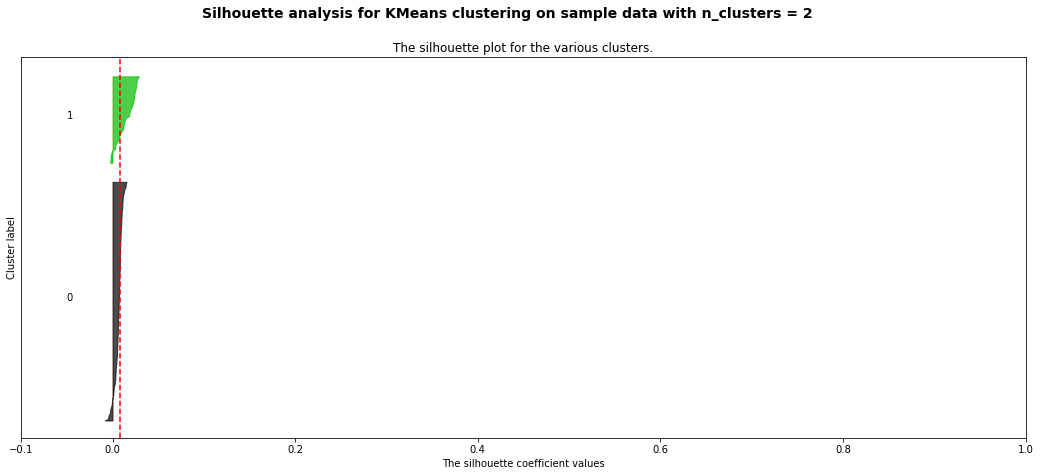

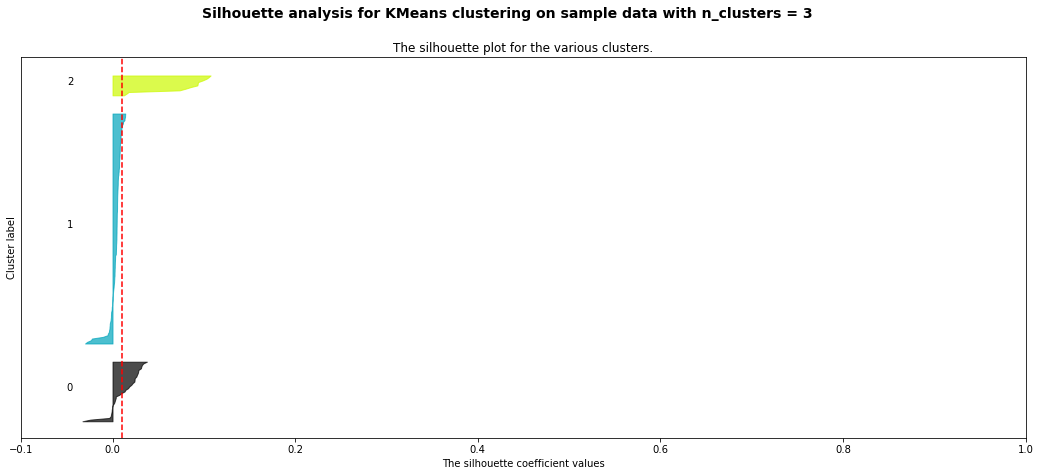

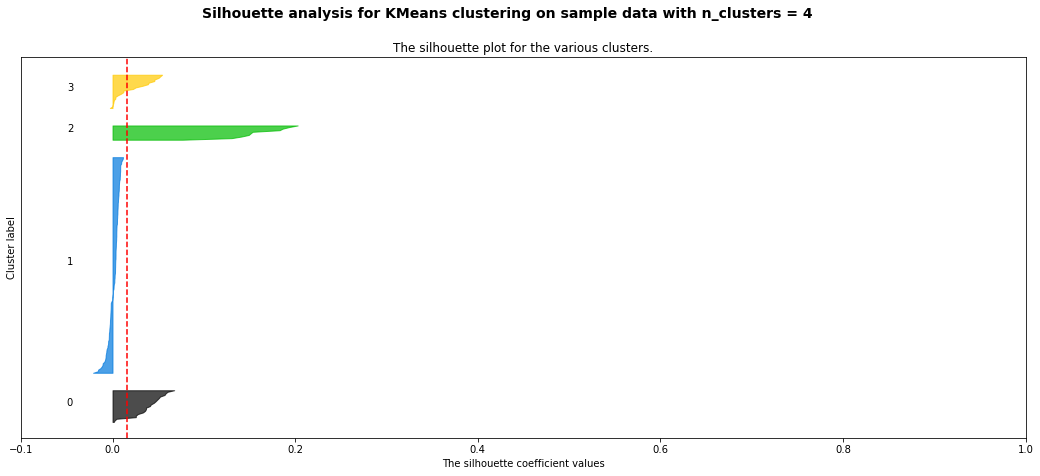

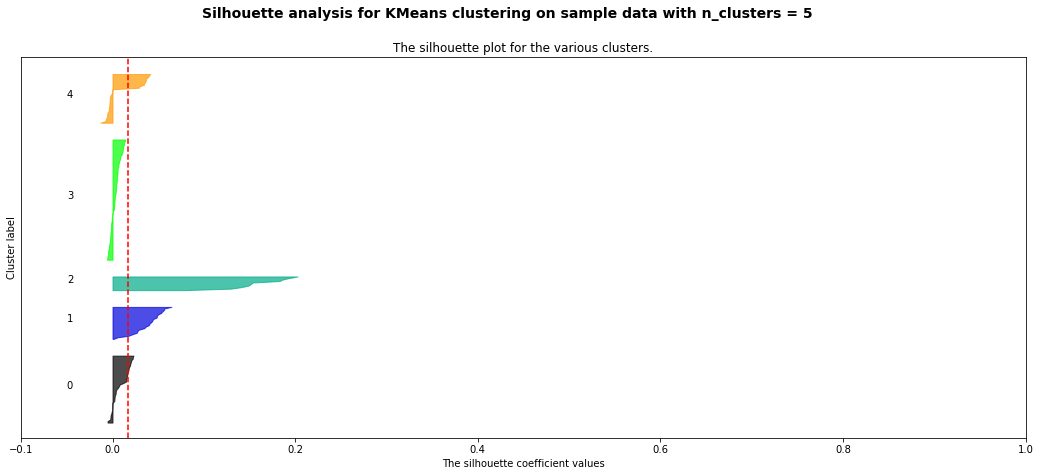

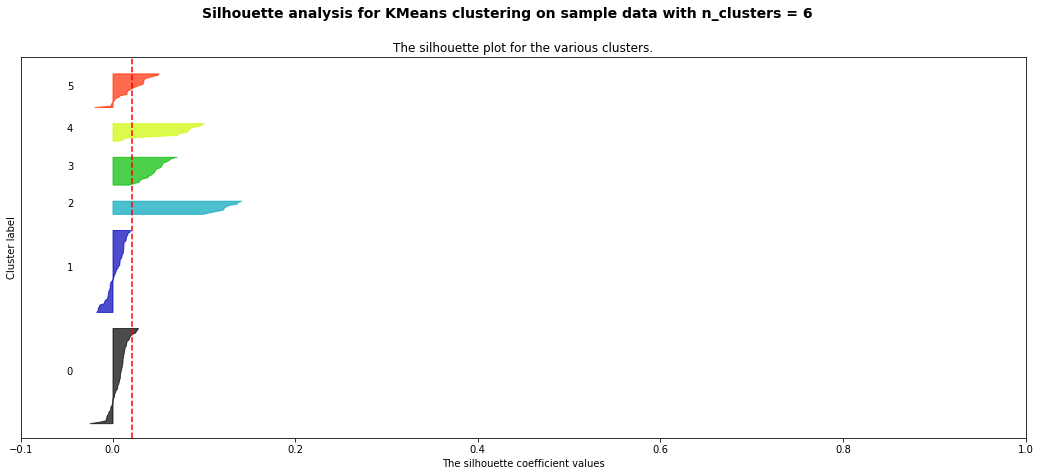

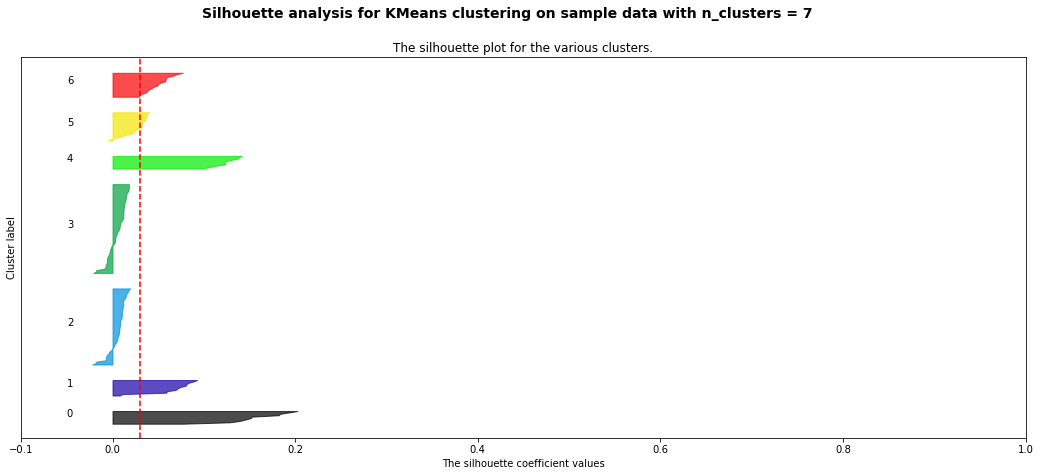

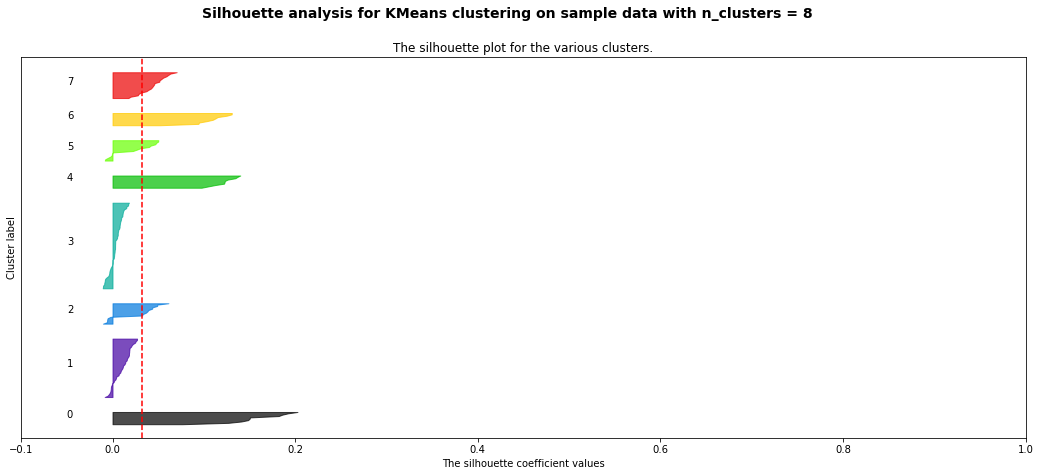

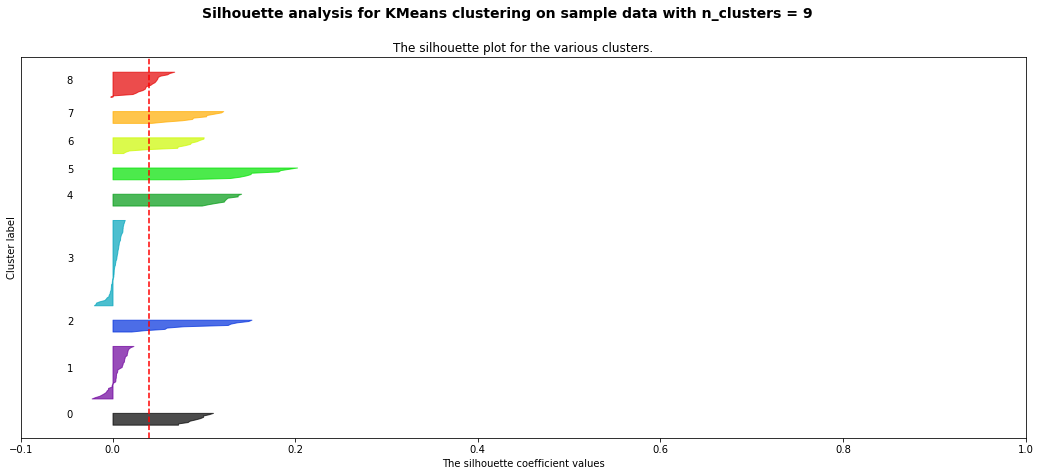

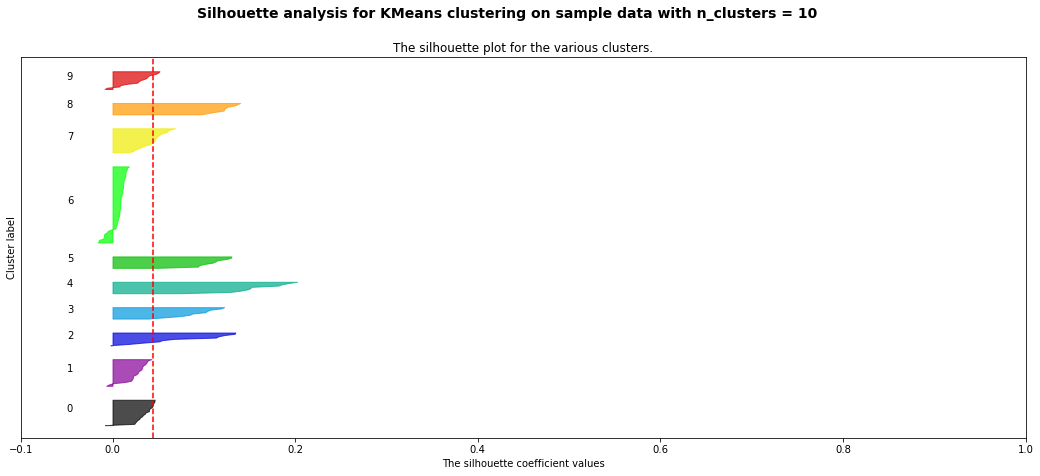

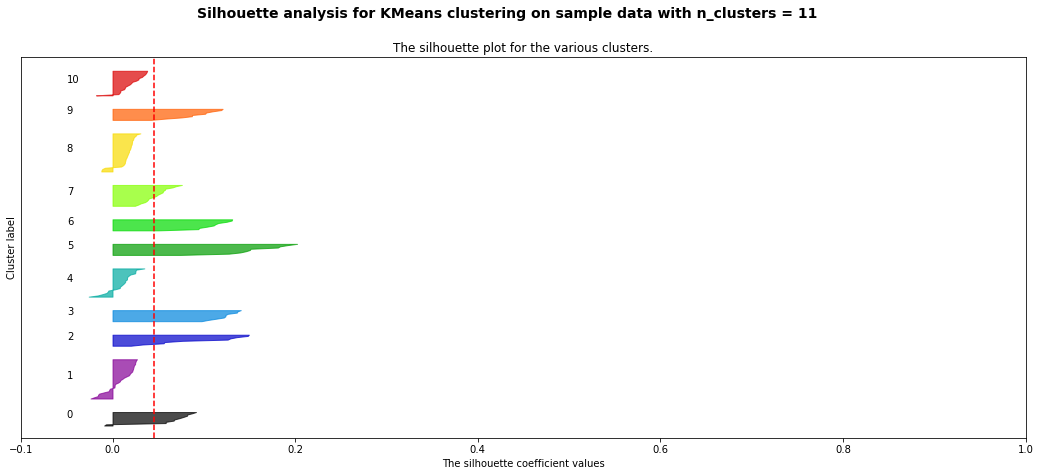

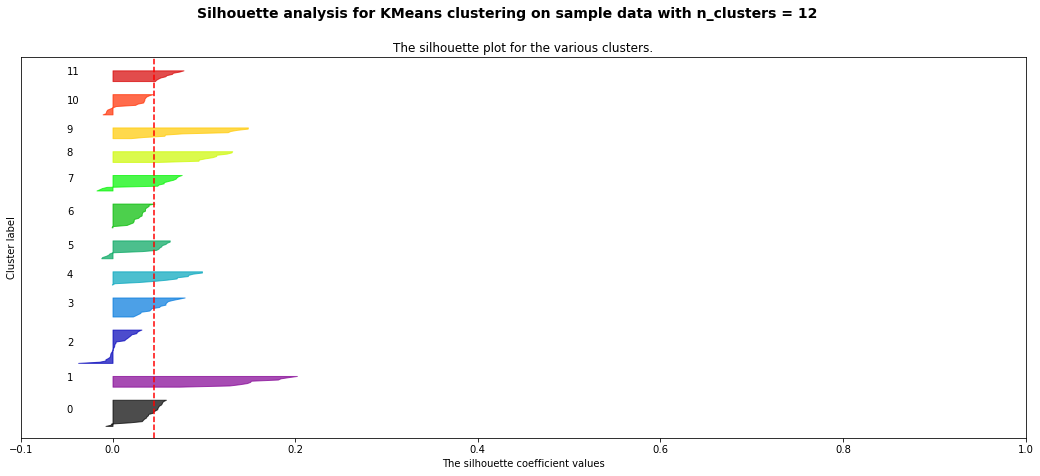

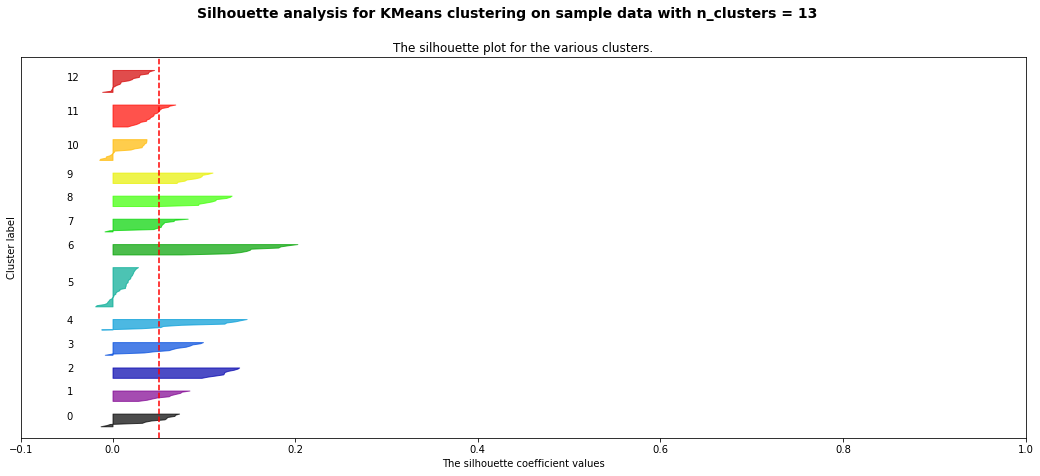

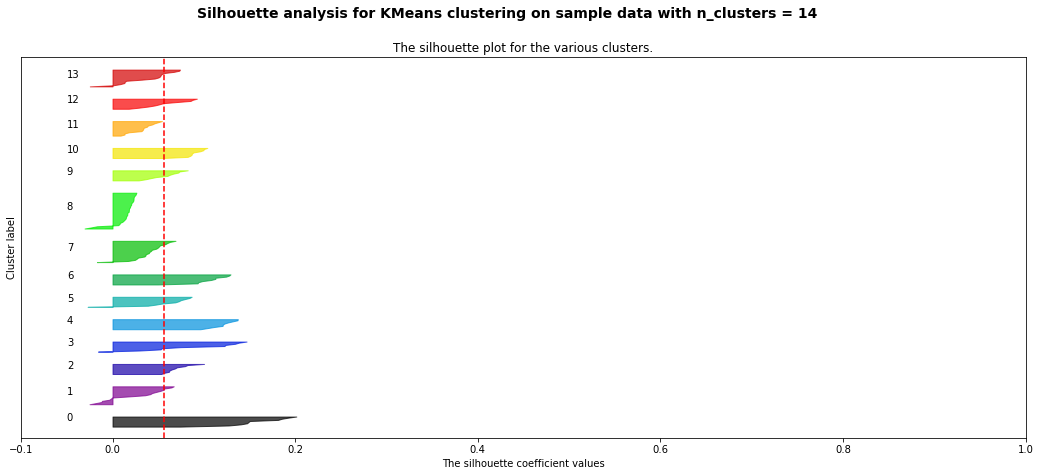

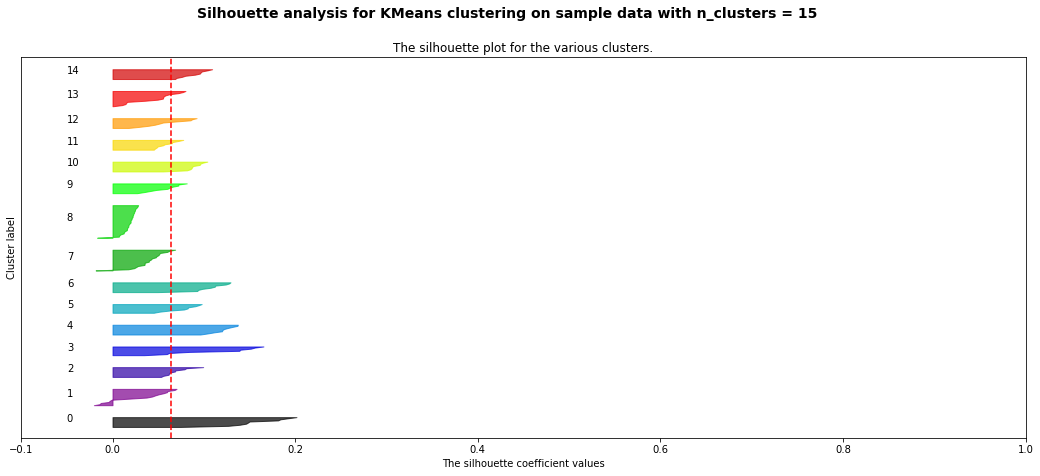

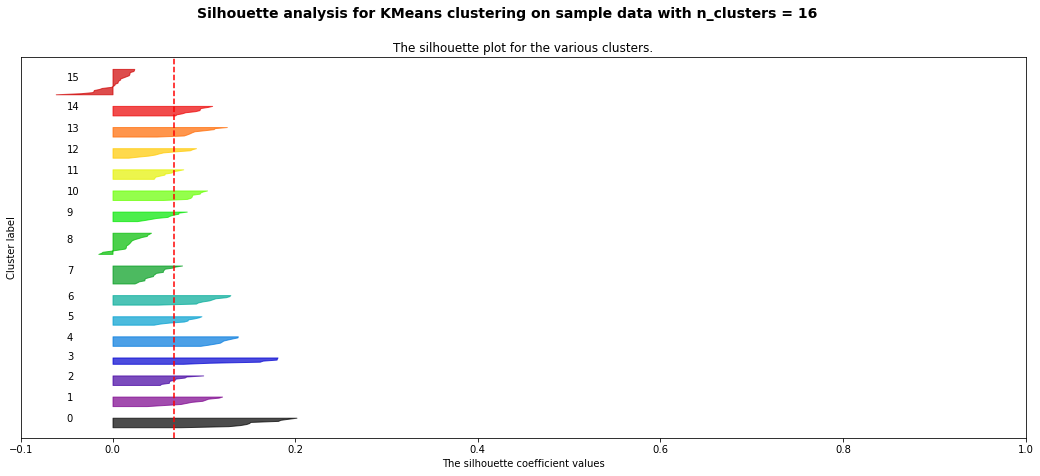

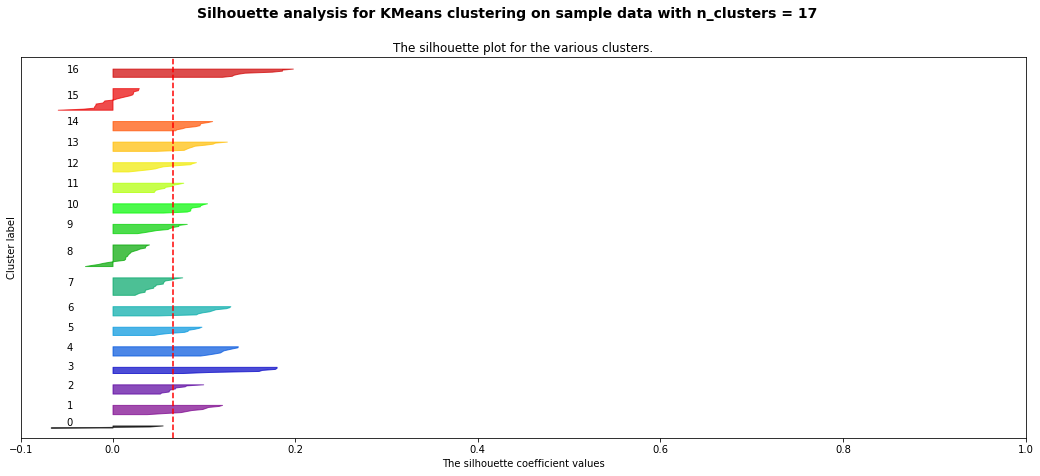

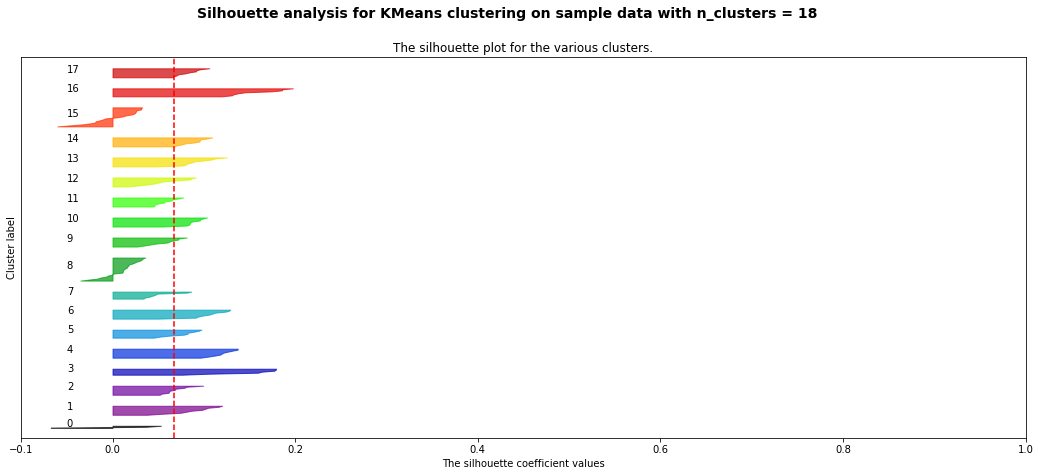

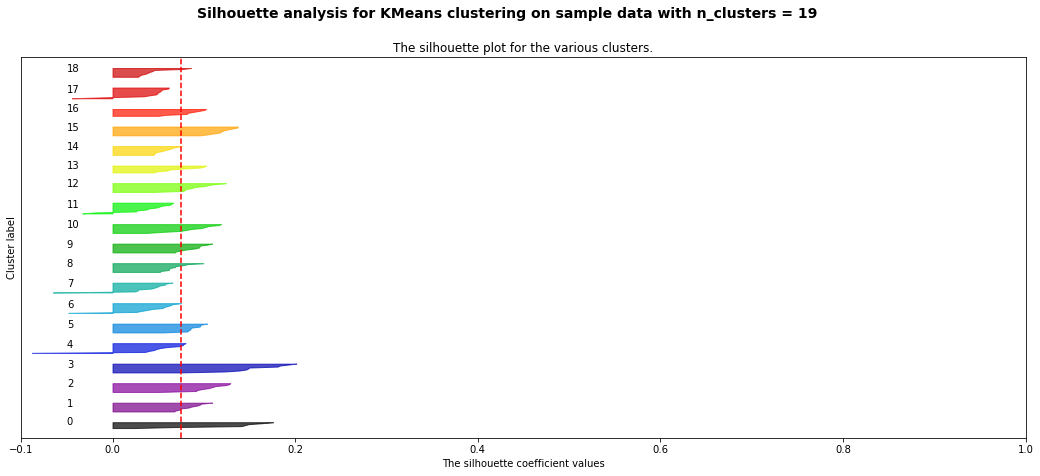

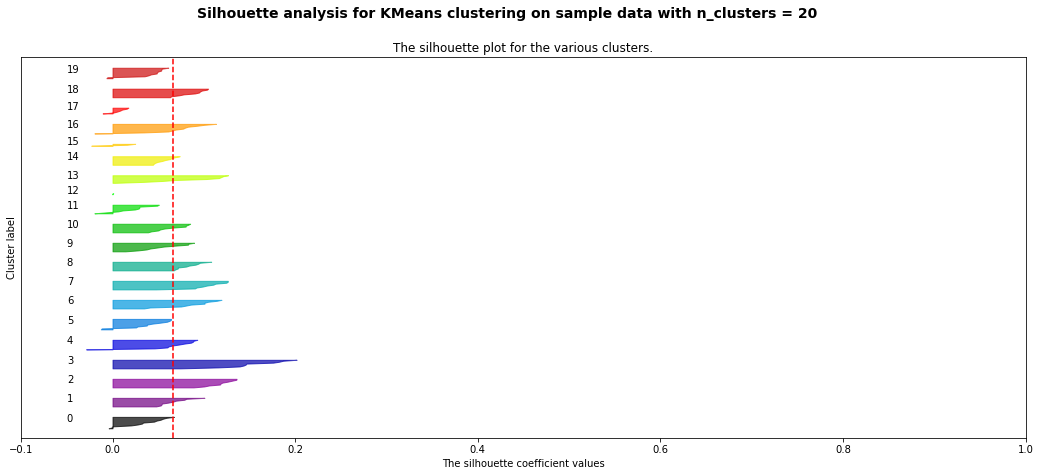

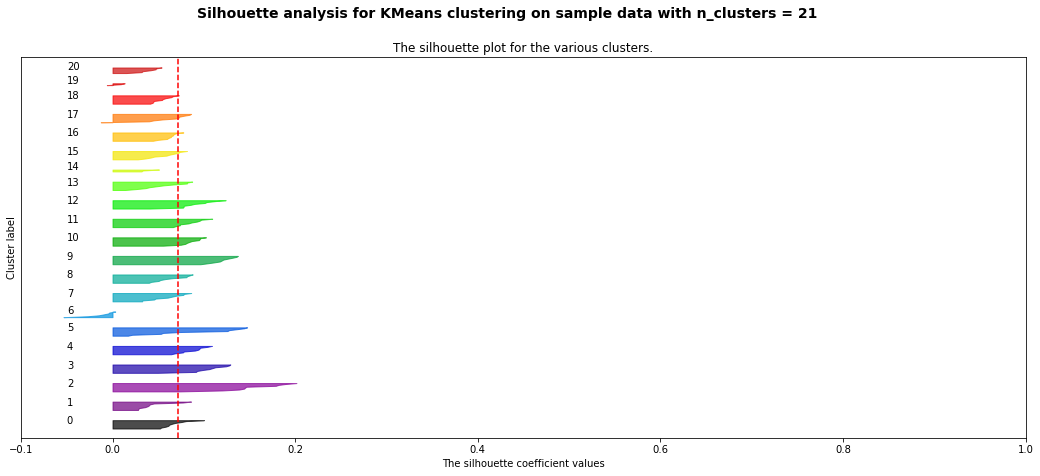

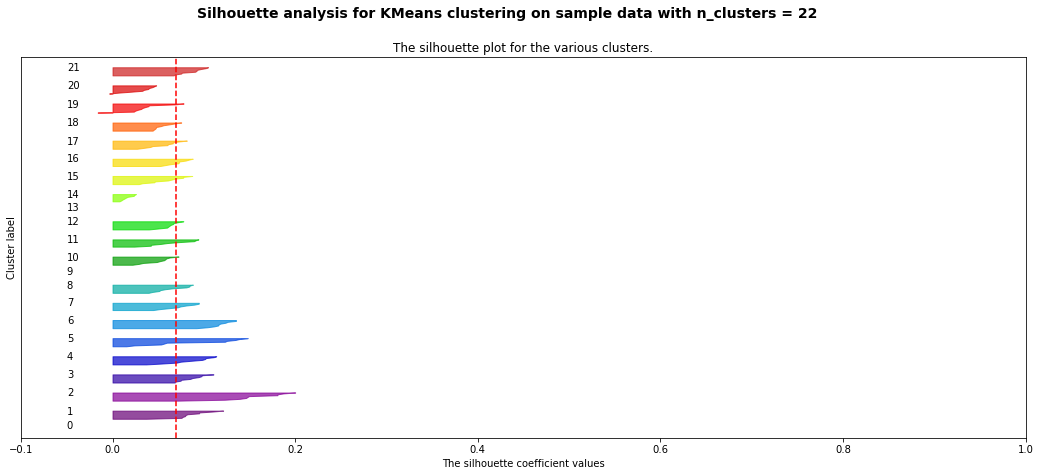

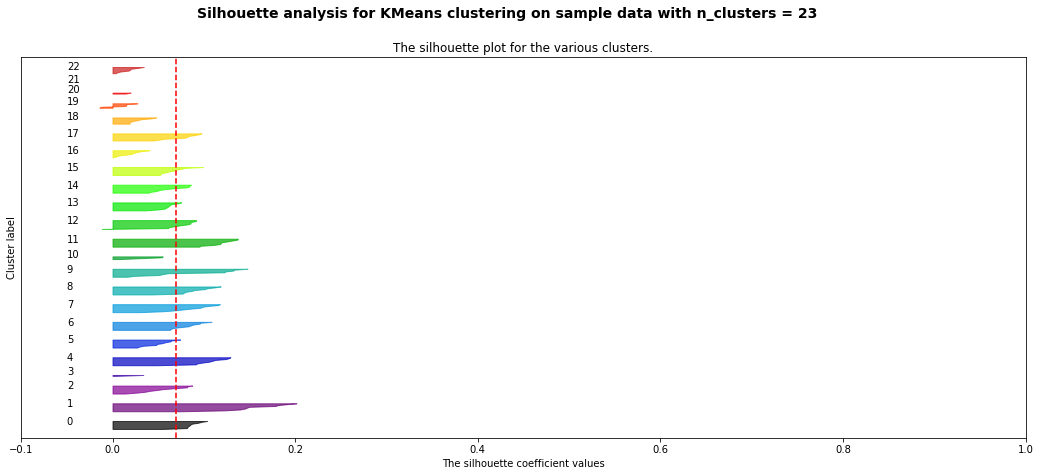

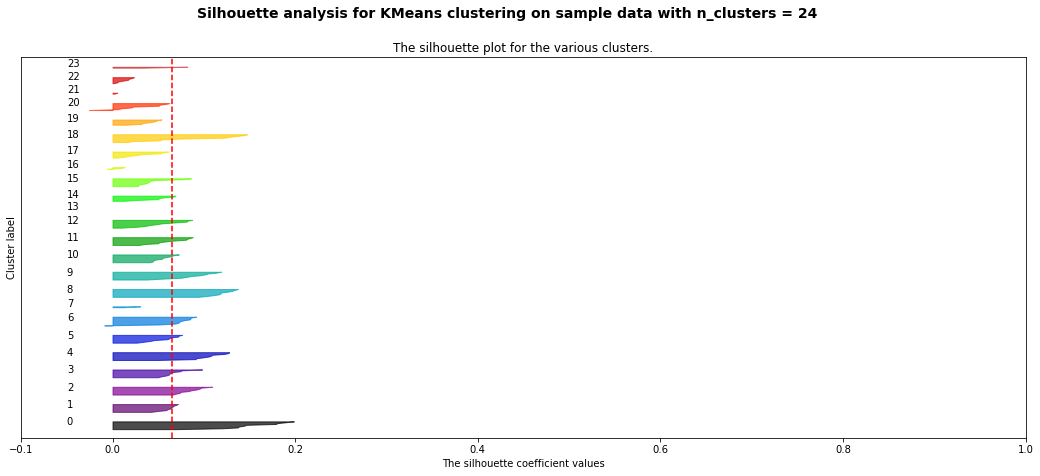

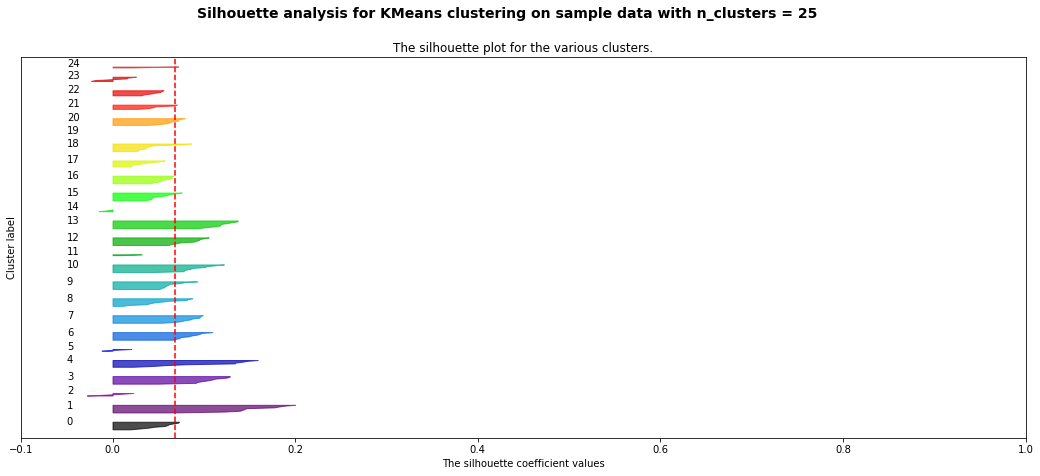

In [88]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

# Generating the sample data from make_blobs

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]

average_silhouette_scores = []

def k_means_cluster_count_tuner(tdm_matrix):

    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, ax1 = plt.subplots(1, 1)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(tdm_matrix) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, n_init=10, random_state=10)
        cluster_labels = clusterer.fit_predict(tdm_matrix)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(tdm_matrix, cluster_labels)
        print(
            "For n_clusters =",
            n_clusters,
            "The average silhouette_score is :",
            silhouette_avg,
        )
        average_silhouette_scores.append(silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(tdm_matrix, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        plt.suptitle(
            "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
            % n_clusters,
            fontsize=14,
            fontweight="bold",
        )

    plt.show()


k_means_cluster_count_tuner(tfidf_matrix_method_one)

In [89]:
import plotly.express as px

avg_silhouette_score_dic = {'Number of Clusters':range_n_clusters, 'Average Silhouette Score':average_silhouette_scores}
avg_silhouette_score_df = pd.DataFrame(avg_silhouette_score_dic)


fig = px.line(avg_silhouette_score_df, x = "Number of Clusters", y = "Average Silhouette Score",
             title = "Average Silhouette Score By Number of Clusters")

fig.update_layout(height = 600, xaxis_title = 'Number of Clusters')

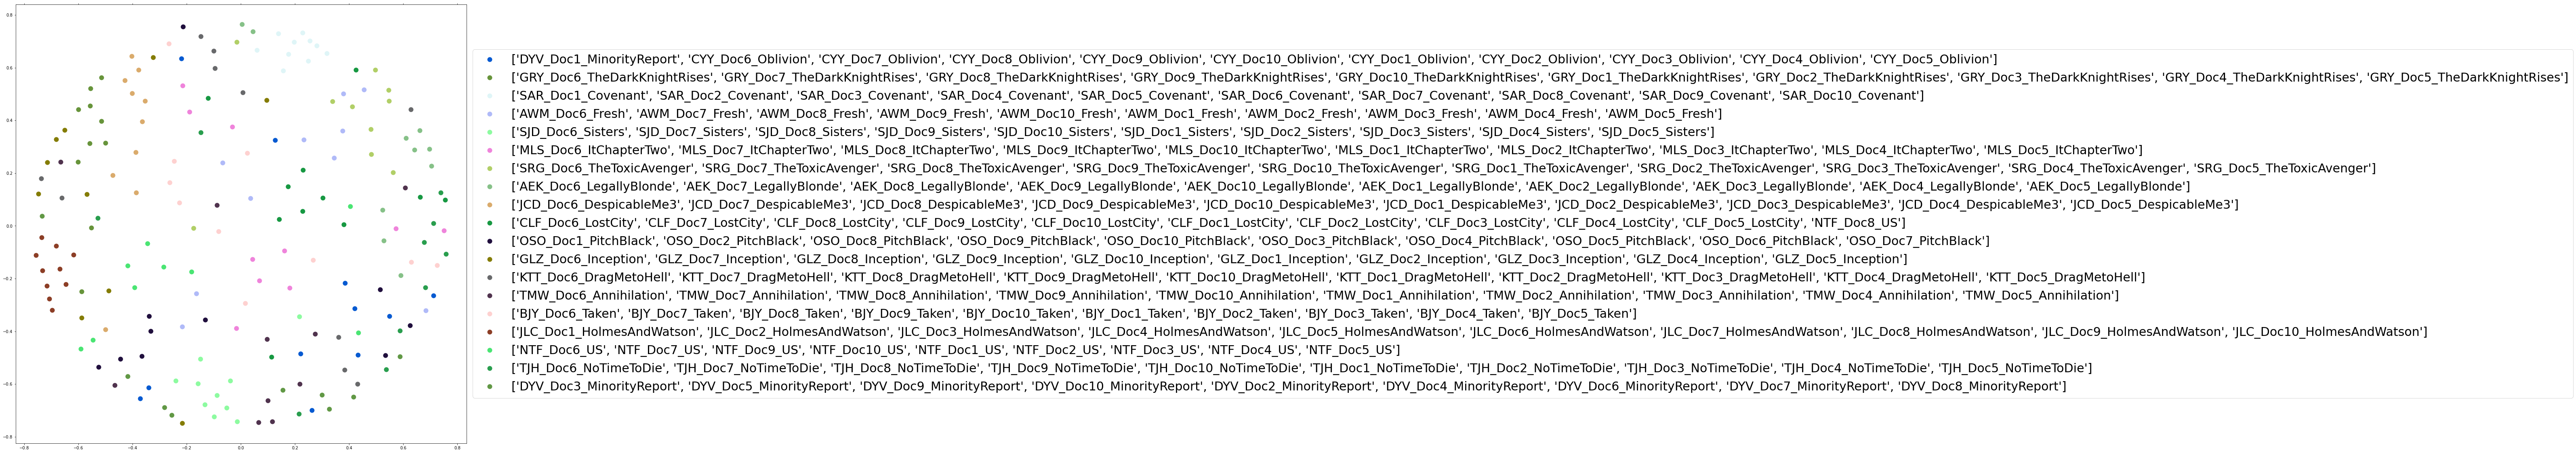

In [90]:
def k_means(titles, tdm_matrix, k, processed_text):
    
    #this is a function to generate the k-means output using the tfidf matrix.  Inputs 
    #to the function include: titles of text, processed text, and desired k value. 
    #Returns dataframe indicating cluster number per document

    km = KMeans(n_clusters=k, random_state =89)
    km.fit(tdm_matrix)
    clusters = km.labels_.tolist()

    Dictionary={'Doc Name':titles, 'Cluster':clusters,  'Text': processed_text}
    frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])
    #dictionary to store clusters and respective titles
    cluster_title={}

    #note doc2vec clusters will not have individual words due to the vector representation
    #is based on the entire document not indvidual words. As a result, there won't be individual
    #word outputs from each cluster.   
    for i in range(k):
        temp=frame[frame['Cluster']==i]
        temp_title_list=[]
        for title in temp['Doc Name']:
            temp_title_list.append(title)
        cluster_title[i]=temp_title_list

    return cluster_title,clusters,frame


def plot_tfidf_matrix(cluster_title, clusters, TFIDF_matrix):
    # convert two components as we're plotting points in a two-dimensional plane
    # "precomputed" because we provide a distance matrix
    # we will also specify `random_state` so the plot is reproducible.

    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
    dist = 1 - cosine_similarity(TFIDF_matrix)
    pos = mds.fit_transform(dist)  # shape (n_components, n_samples)
    xs, ys = pos[:, 0], pos[:, 1]


    #set up colors per clusters using a dict.  number of colors must correspond to K
    cluster_colors = {0: 'black', 1: 'grey', 2: 'blue', 3: 'rosybrown', 4: 'firebrick', 
                      5:'red', 6:'darksalmon', 7:'sienna', 8:'darkorange3', 9:'darkorchid3',
                     10:'seagreen2', 11:'deeppink2', 12:'gold2', 13:'indigo',
                     14:'olive', 15:'sepia', 16:'slateblue2', 17:'maroon',
                     18:'aqua'}

    #set up cluster names using a dict.  
    cluster_dict=cluster_title

    #create data frame that has the result of the MDS plus the cluster numbers and titles
    df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=range(0,len(clusters)))) 

    #group by cluster
    groups = df.groupby('label')

    fig, ax = plt.subplots(figsize=(20,20)) # set size
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    #iterate through groups to layer the plot
    #note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
    for name, group in groups:
        
        r = random.random()
        b = random.random()
        g = random.random()
        color = (r, g, b)
        
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
                label=cluster_dict[name], color=color, 
                mec='none')
        ax.set_aspect('auto')
        ax.tick_params(\
            axis= 'x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelbottom='on')
        ax.tick_params(\
            axis= 'y',         # changes apply to the y-axis
            which='both',      # both major and minor ticks are affected
            left='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelleft='on')

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 30})      #show legend with only 1 point



#tfidf_matrix = tfidf(final_processed_text, titles, ngram_range = (1,1))

cluster_title, clusters, k_means_df = k_means(titles, 
                                              tdm_matrix = tfidf_matrix_method_one,
                                              k=19,
                                              processed_text = final_processed_text_method_one)

cluster_title[9]

plot_tfidf_matrix(cluster_title, clusters, tfidf_matrix_method_one)


In [21]:
review_type_labels = corpus_df['Review Type (pos or neg)'].apply(lambda x: 0 if x.lower().split(' ')[0] == 'negative' else 1)
print(review_type_labels)

Doc_ID
101    0
102    0
103    0
104    0
105    0
      ..
213    1
214    1
215    1
216    1
217    1
Name: Review Type (pos or neg), Length: 190, dtype: int64


##### Data Wrangling and Vectorization Method 4

For n_clusters = 2 The average silhouette_score is : 0.008663709066639933
For n_clusters = 3 The average silhouette_score is : 0.01107107408302278
For n_clusters = 4 The average silhouette_score is : 0.014439666688113582
For n_clusters = 5 The average silhouette_score is : 0.01759062813683313
For n_clusters = 6 The average silhouette_score is : 0.023869546822147078
For n_clusters = 7 The average silhouette_score is : 0.03668387668401417
For n_clusters = 8 The average silhouette_score is : 0.03511409353055053
For n_clusters = 9 The average silhouette_score is : 0.04149921108580751
For n_clusters = 10 The average silhouette_score is : 0.04502605575832928
For n_clusters = 11 The average silhouette_score is : 0.04776189430411533
For n_clusters = 12 The average silhouette_score is : 0.051901391086749606
For n_clusters = 13 The average silhouette_score is : 0.06140140202551258
For n_clusters = 14 The average silhouette_score is : 0.059039888936819766
For n_clusters = 15 The average silhouett

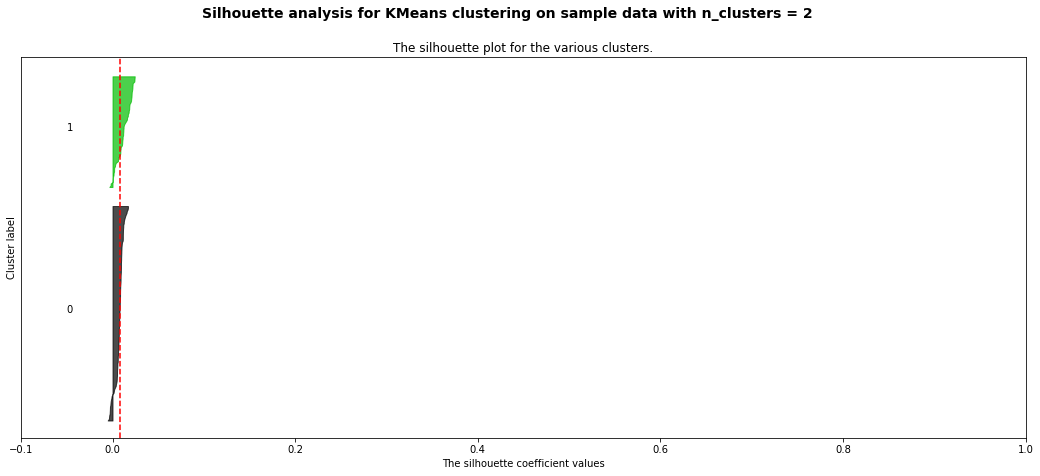

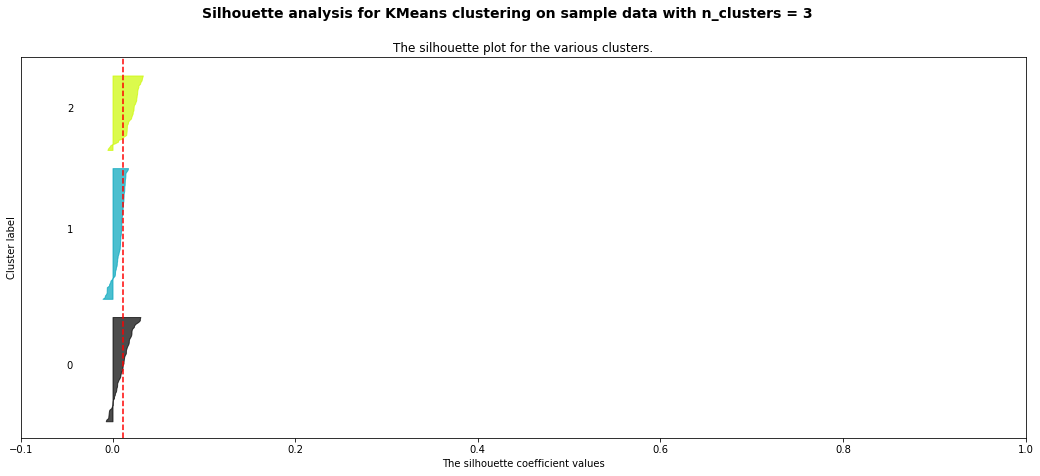

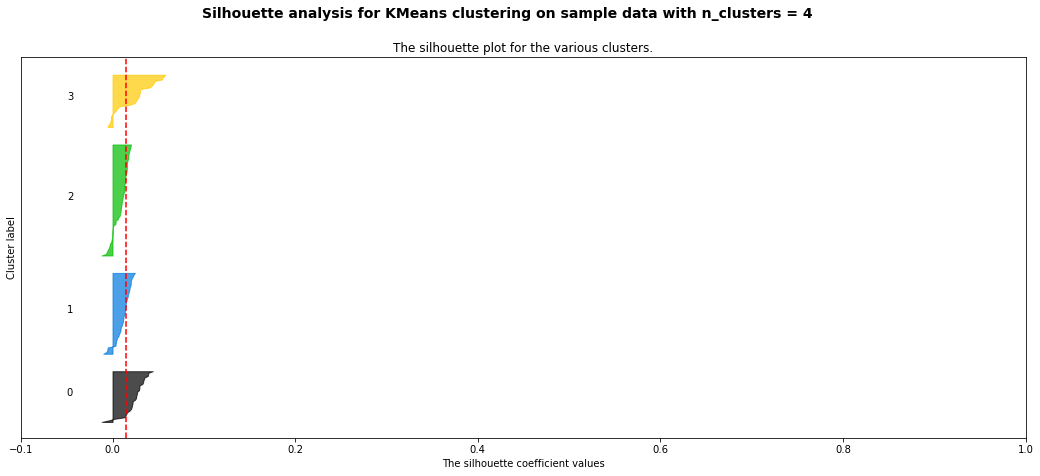

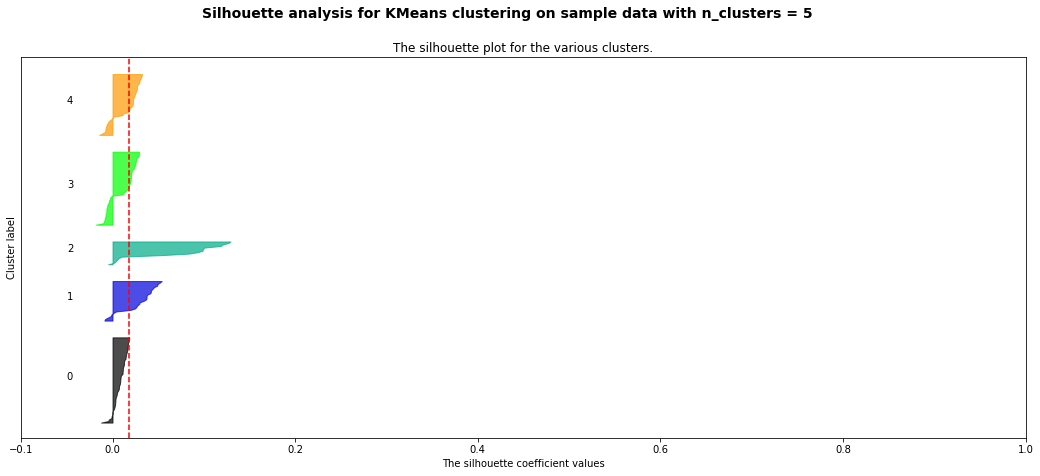

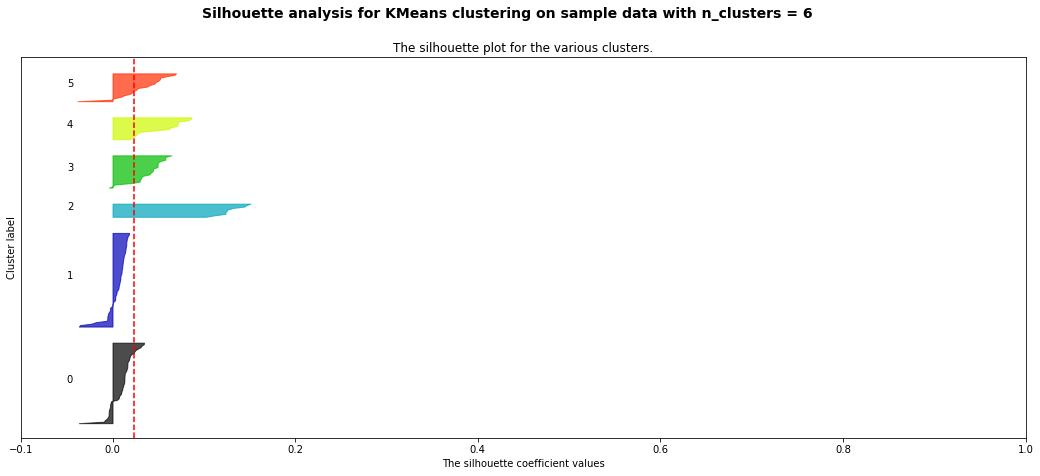

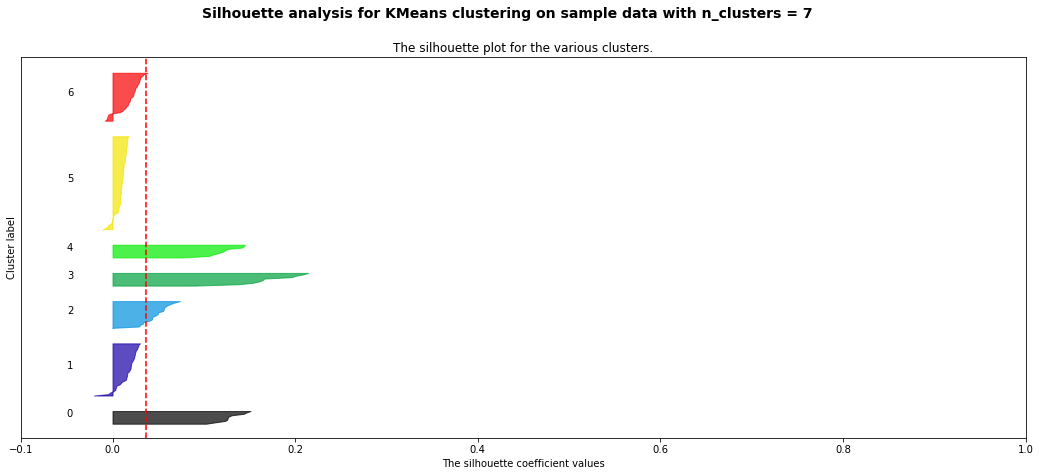

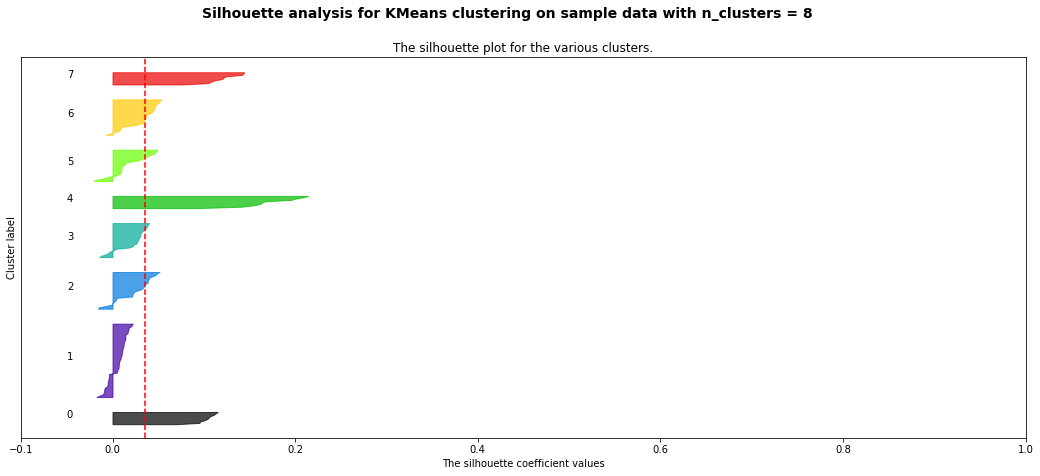

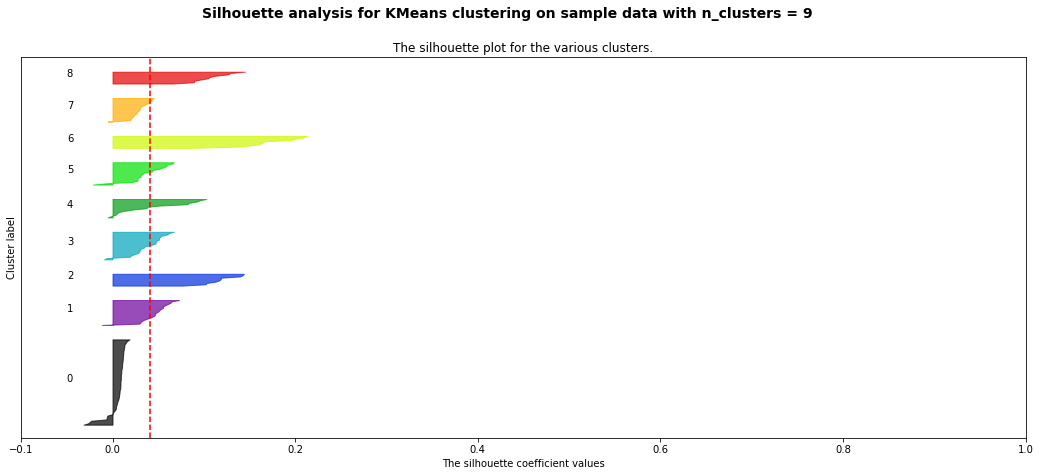

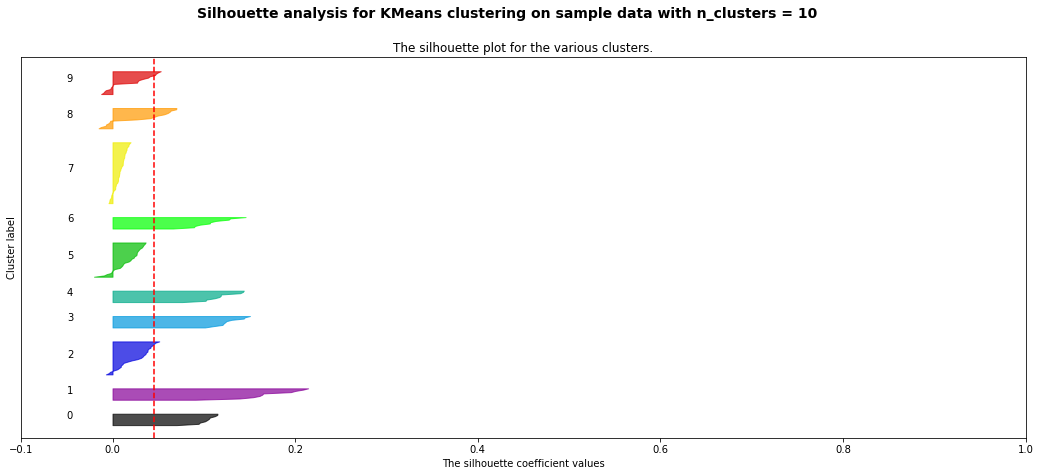

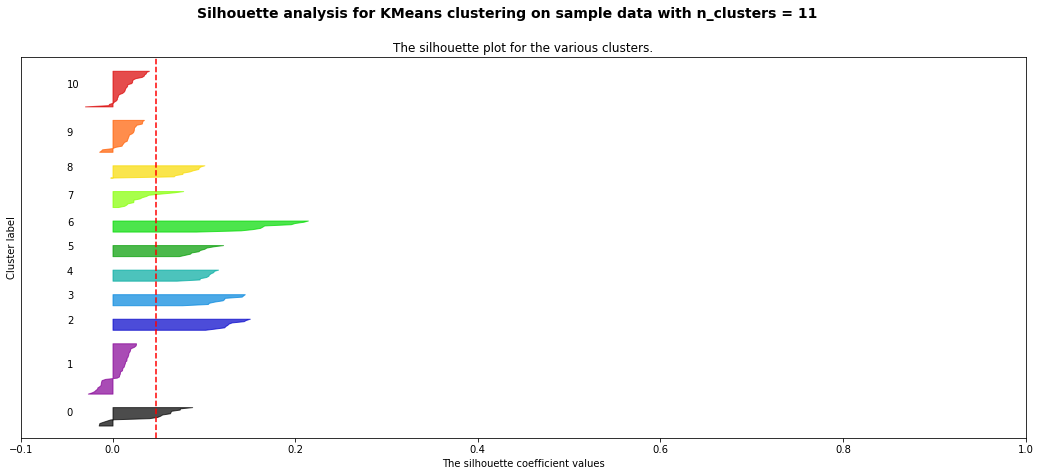

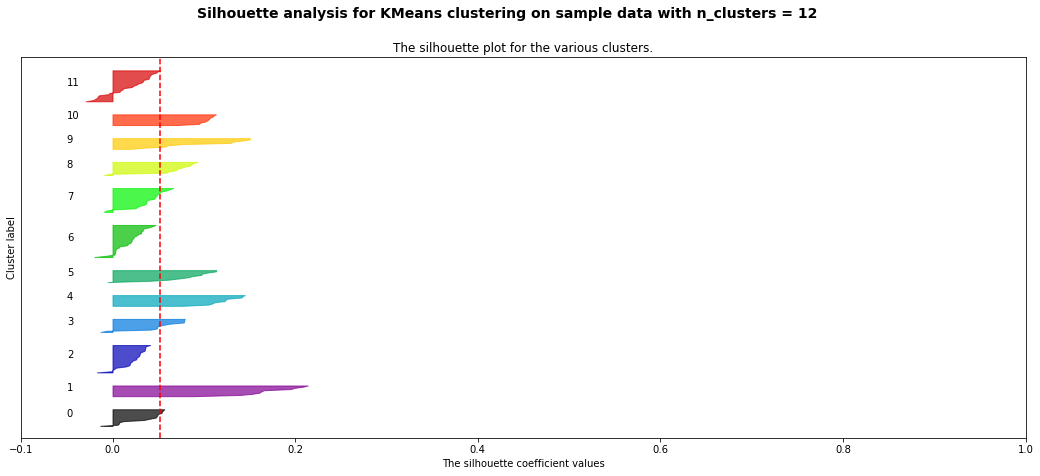

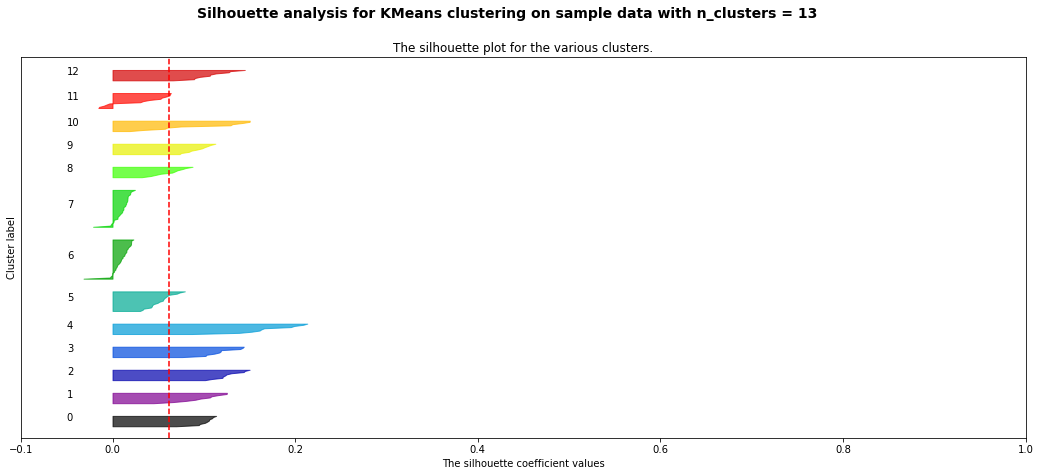

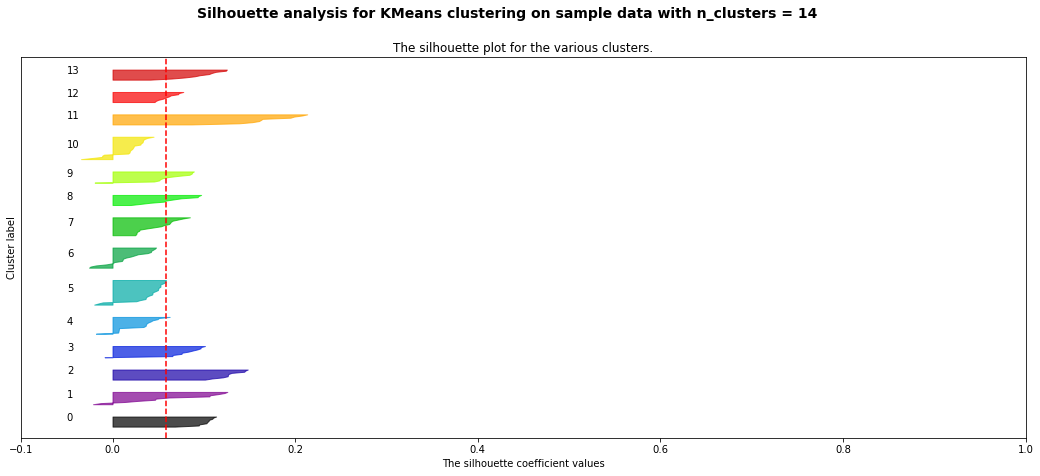

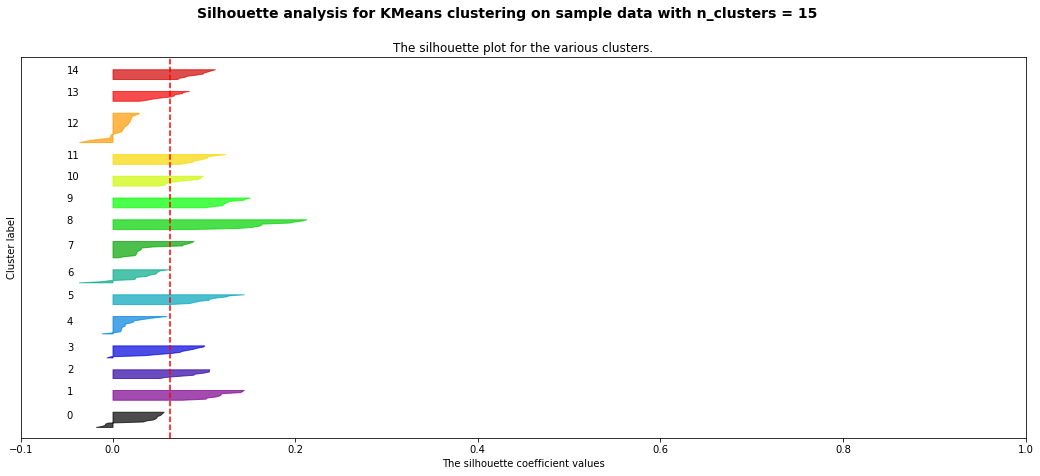

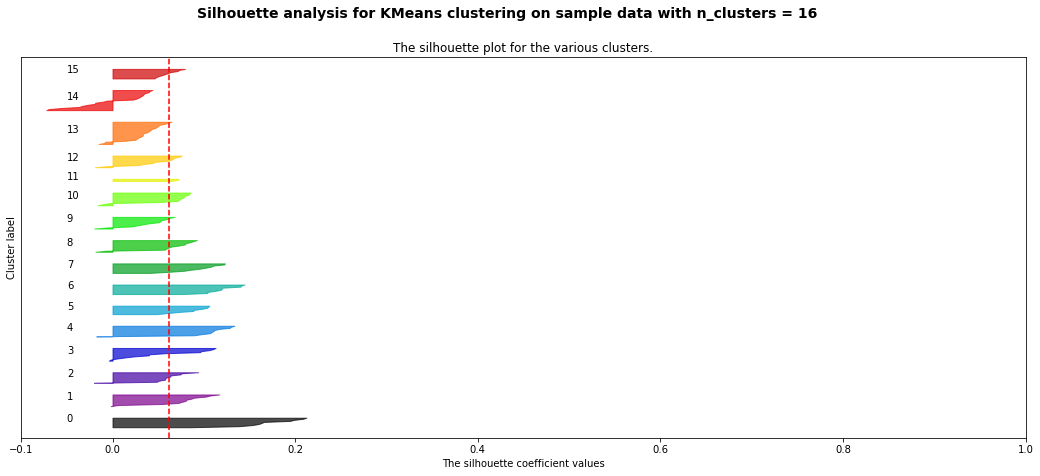

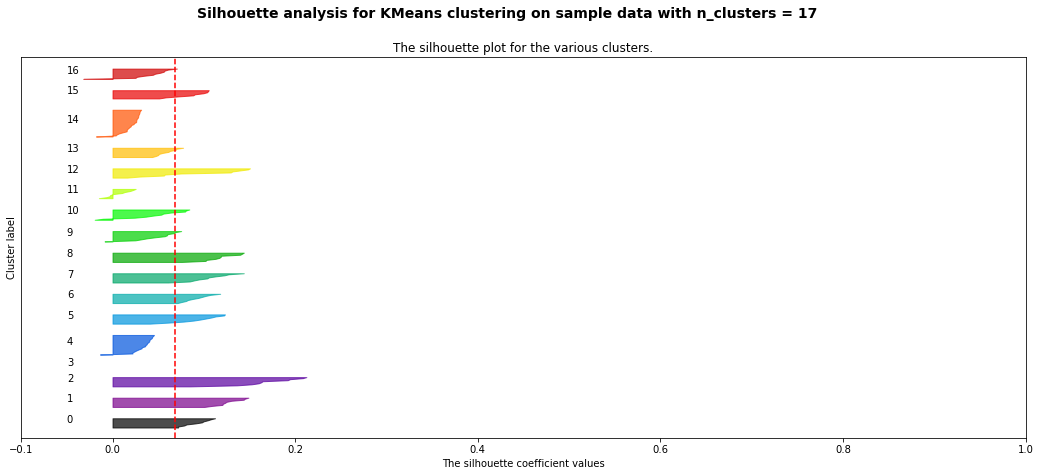

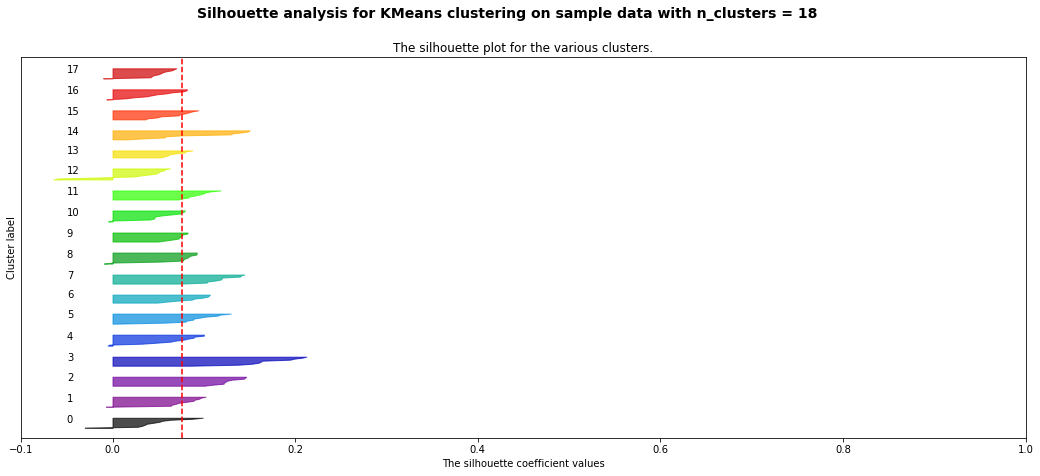

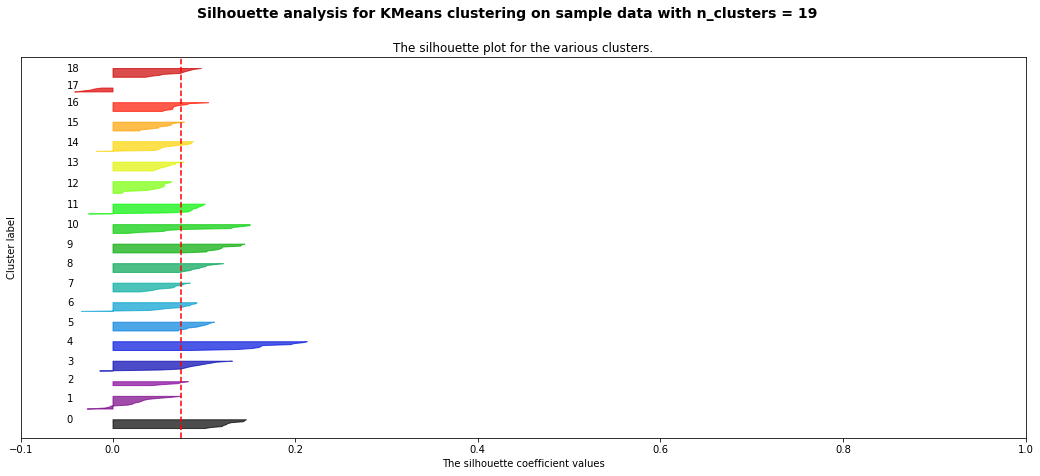

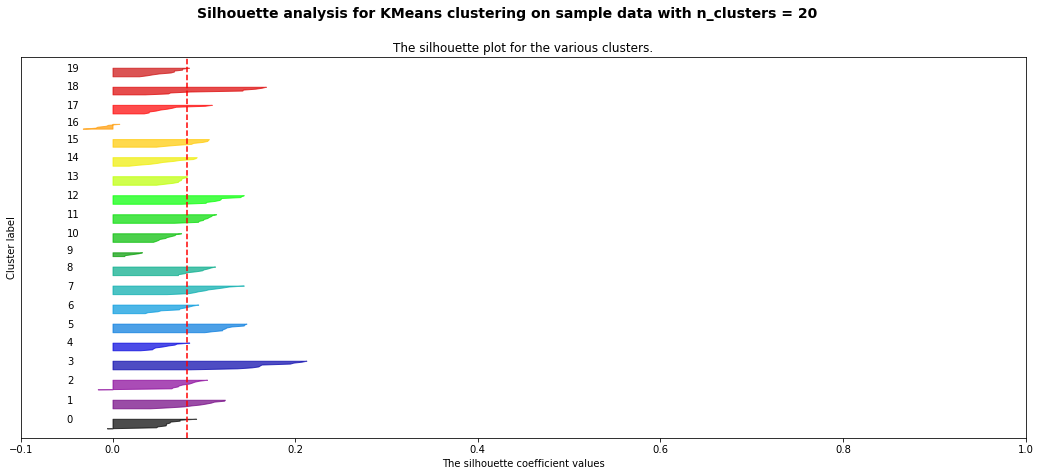

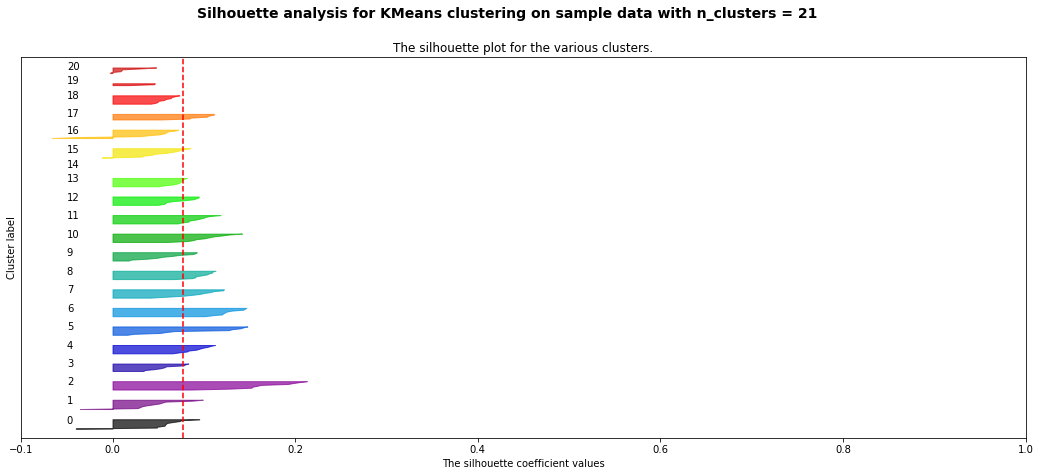

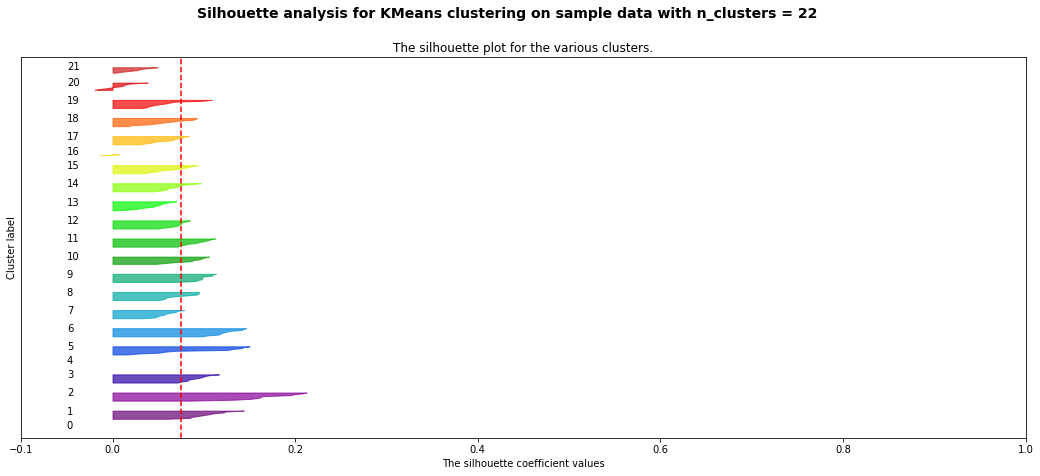

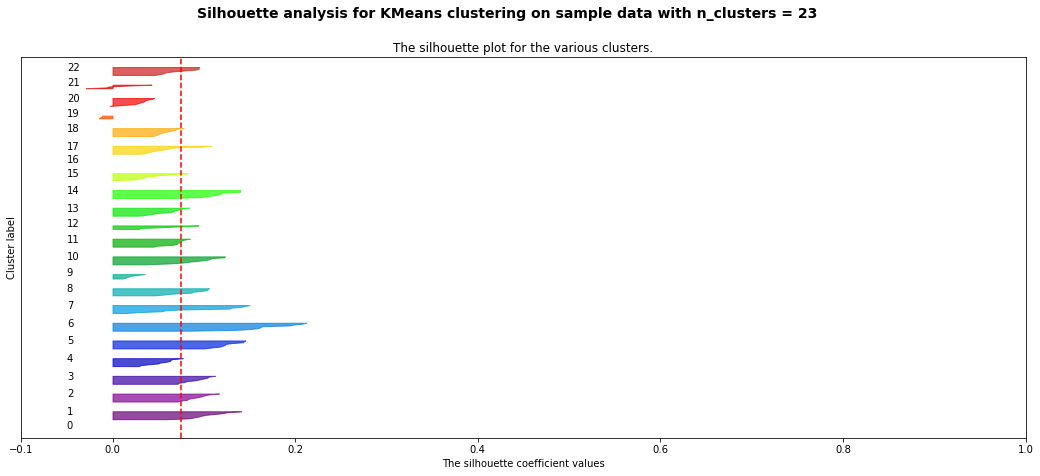

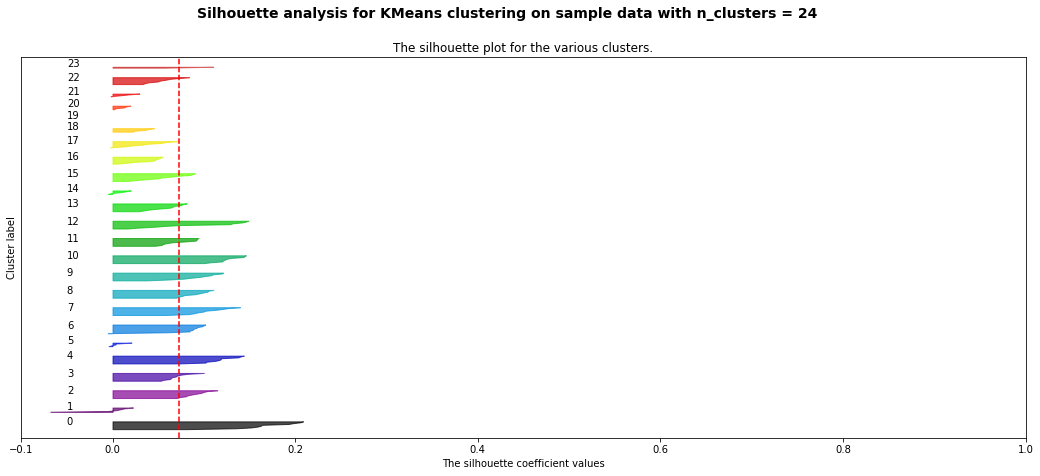

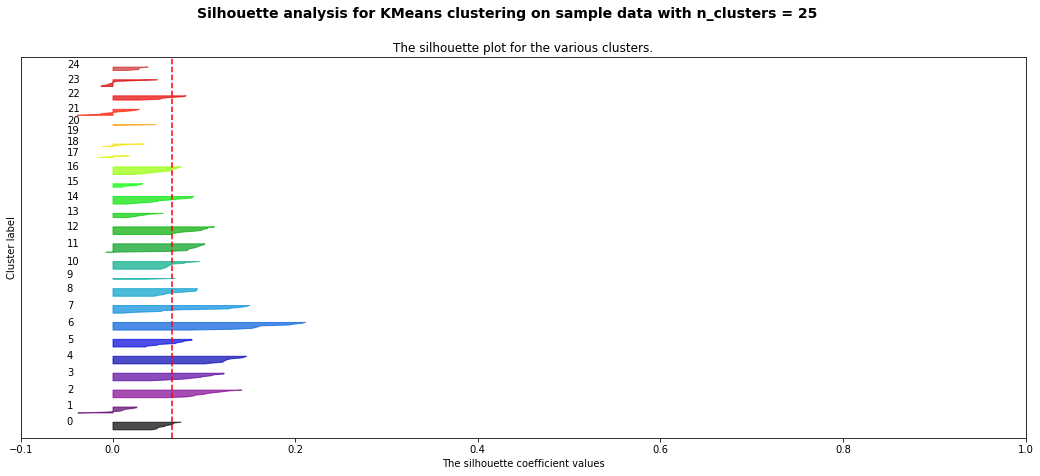

In [91]:
average_silhouette_scores = []

k_means_cluster_count_tuner(tfidf_matrix_method_four)

In [92]:
avg_silhouette_score_dic = {'Number of Clusters':range_n_clusters, 'Average Silhouette Score':average_silhouette_scores}
avg_silhouette_score_df = pd.DataFrame(avg_silhouette_score_dic)


fig = px.line(avg_silhouette_score_df, x = "Number of Clusters", y = "Average Silhouette Score",
             title = "Average Silhouette Score By Number of Clusters")

fig.update_layout(height = 600, xaxis_title = 'Number of Clusters')

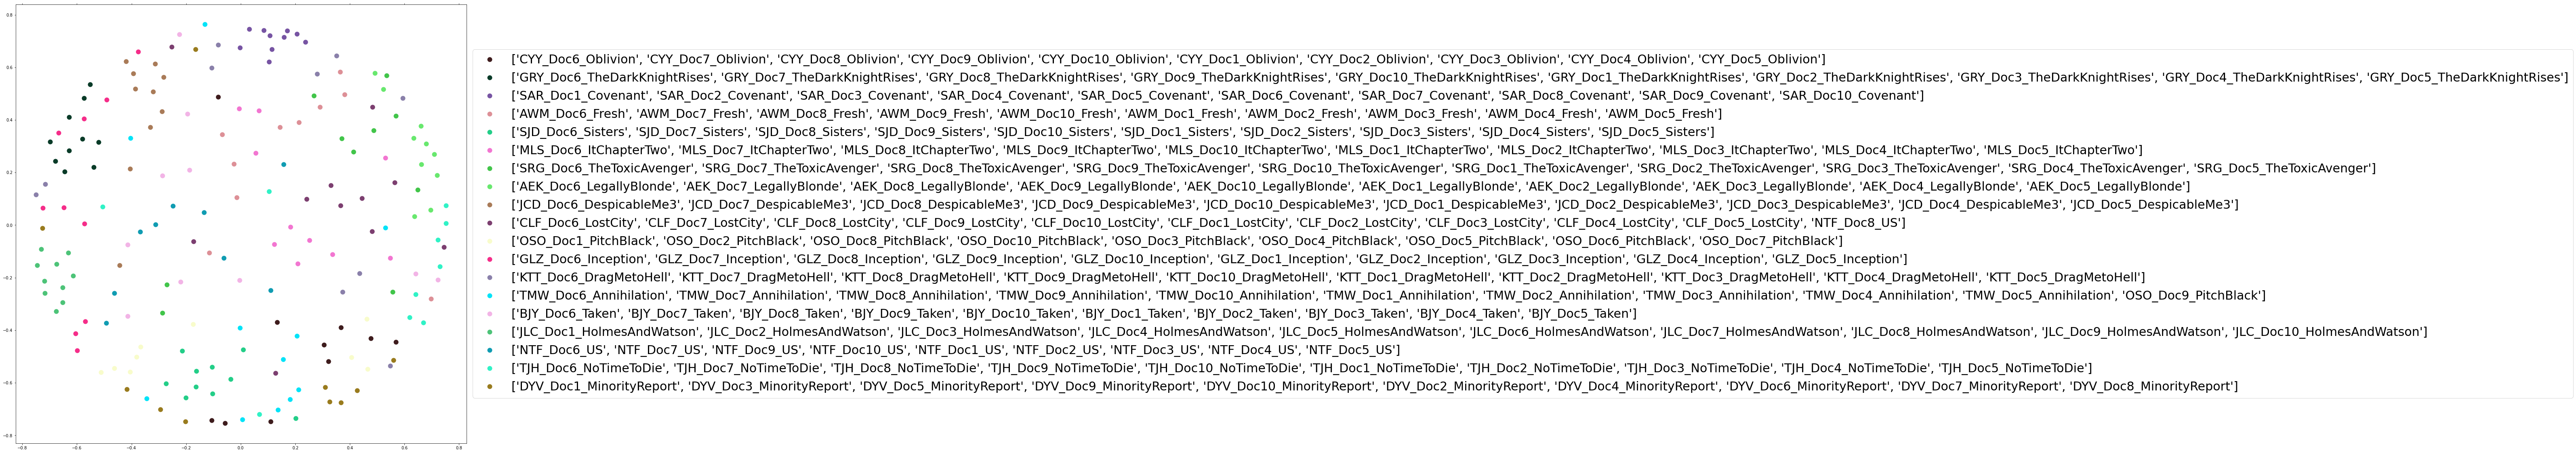

In [93]:
cluster_title, clusters, k_means_df = k_means(titles, 
                                              tdm_matrix = tfidf_matrix_method_four,
                                              k=19,
                                              processed_text = final_processed_text_method_four)

cluster_title[9]

plot_tfidf_matrix(cluster_title, clusters, tfidf_matrix_method_four)


#### 1.4.2) Hierarchical Clustering Experiments

In [22]:
########################### THIS MAY BE A STRETCH GOAL SECTION ################################################

#### 1.4.3) DBSCAN Clustering Experiments

In [23]:
################################ THIS MAY BE A STRETCH GOAL SECTION ##########################################

## 2) Sentiment Analysis

Let's examine the effectiveness of various classification algorithms for conducting sentiment analysis on our corpus.  We can leverage Random Forest Classification, Naive Bayes Classification, and Support Vector Machine Classification to predict which reviews are positive or negative.

### 2.1) Random Forest Classifier Experiments

Let's apply random forest classification to our corpus to see how effectively we can predict which reviews are positive or negative.

##### Data Wrangling and Vectorization Method 1

Random Forest Classifier
Accuracy =  36.8 %
F1 Score =  0.368
Precision =  0.375
Recall =  0.3
AUC =  0.456
 
Confusion Matrix


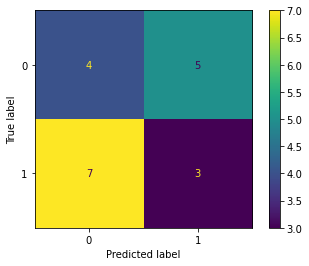

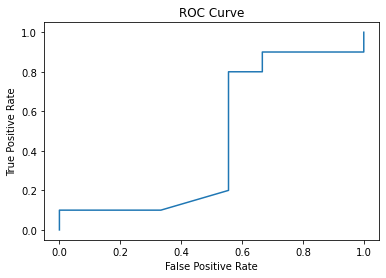

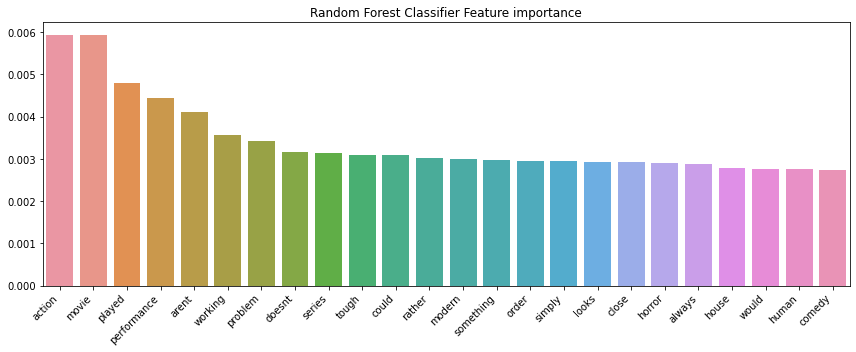

In [72]:
def classifiers(x, y, model_type, cv = 3):
    
    #this function is to fit 3 different model scenarios.  Support vector machines, logistic regressions, naive bayes.
    #svm = Support vector machin
    #logistic = Logistic regression
    #naive_bayes = Naive Bayes Multinomial
    
    #can define cv value for cross validation.
    
    #function returns the train test split scores of each model.
    
    number_of_categories = y.nunique()
    
    if model_type == 'svm':
        print("Support Vector Machine Classifier")
        model = SVC(probability = True)

    elif model_type == 'logistic':
        print("logistic Regression Classifier")
        model = LogisticRegression()

    elif model_type == 'naive_bayes':
        print("Naive Bayes Classifier")
        model = MultinomialNB()
    
    elif model_type == 'randomforest':
        print("Random Forest Classifier")
        model = RandomForestClassifier(n_estimators = 100, max_features = 'sqrt', bootstrap = True, max_samples = 115)

    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.10, random_state=23)
    model.fit(X_train, y_train)

    
    predictions = model.predict(X_test)
    probabilities = model.predict_proba(X_test)[:,1]
    
    accy = accuracy_score(y_test, predictions) 
    F1_Score = f1_score(y_test, predictions, average = 'micro')
    print("Accuracy = ", round(100*accy,1), "%")
    print("F1 Score = ", round(F1_Score,3))

    if number_of_categories == 2:
        precision = precision_score(y_test, predictions)
        recall = recall_score(y_test, predictions)
        auc = roc_auc_score(y_test, probabilities)
        print("Precision = ", round(precision,3))
        print("Recall = ", round(recall,3))
        print("AUC = ", round(auc, 3))

    print(" ")
    print("Confusion Matrix")
    
    # Create the confusion matrix of the predictions
    cm = confusion_matrix(y_test, predictions)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot();
    
    
    # Create the ROC Curve
    if number_of_categories == 2:
        fpr, tpr, _ = roc_curve(y_test, probabilities)
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
        plt.title('ROC Curve') 
    
    if model_type == 'randomforest':
        # Calculate feature importances
        importances = model.feature_importances_

        # Visualize Feature Importance
        # Sort feature importances in descending order
        indices = np.argsort(importances)[::-1]

        # Rearrange feature names so they match the sorted feature importances
        names = [X_train.columns[i] for i in indices]
        abridged_names = names[1:25]

        plt.figure(figsize = (12, 5))
#       sns.set_style("whitegrid")
        chart = sns.barplot(x = abridged_names, y=importances[indices][1:25])
        plt.xticks(rotation=45, horizontalalignment='right', fontweight='light')
        plt.title('Random Forest Classifier Feature importance')
        plt.tight_layout()
        

    

classifiers(tfidf_matrix_method_one, review_type_labels, 'randomforest')

##### Data Wrangling and Vectorization Method 4

Random Forest Classifier
Accuracy =  47.4 %
F1 Score =  0.474
Precision =  0.5
Recall =  0.2
AUC =  0.494
 
Confusion Matrix


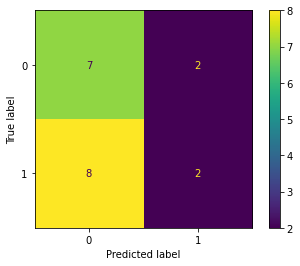

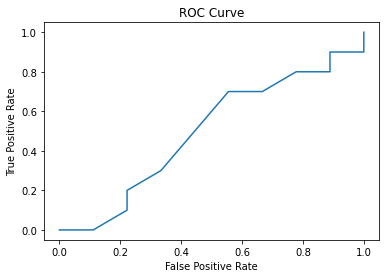

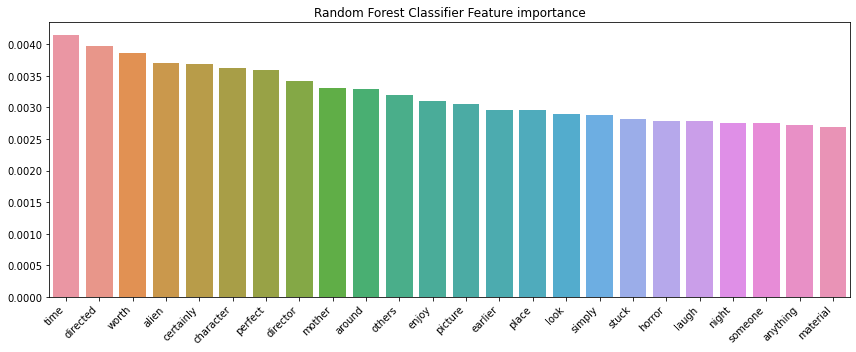

In [73]:
classifiers(tfidf_matrix_method_four, review_type_labels, 'randomforest')

### 2.2) Naive Bayes Classifier Experiments

Let's apply Naive Bayes Classificaiton to our corpus to determine how effectively we can predict which reviews are positive or negative.

##### Data Wrangling and Vectorization Method 1

Naive Bayes Classifier
Accuracy =  36.8 %
F1 Score =  0.368
Precision =  0.333
Recall =  0.2
AUC =  0.322
 
Confusion Matrix


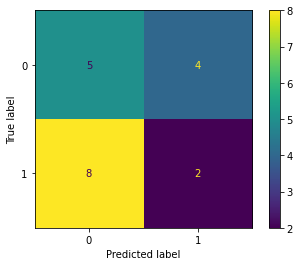

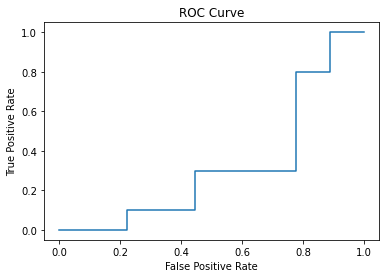

In [25]:
classifiers(tfidf_matrix_method_one, review_type_labels, 'naive_bayes')

##### Data Wrangling and Vectorization Method 4

Naive Bayes Classifier
Accuracy =  42.1 %
F1 Score =  0.421
Precision =  0.429
Recall =  0.3
AUC =  0.389
 
Confusion Matrix


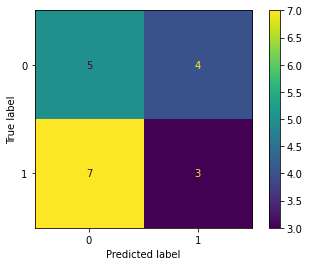

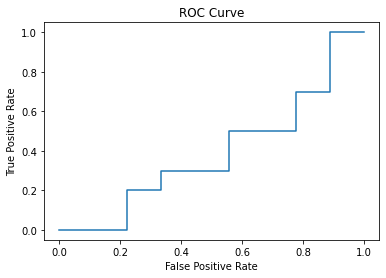

In [67]:
classifiers(tfidf_matrix_method_four, review_type_labels, 'naive_bayes')

### 2.3) Support Vector Machine Classification Experiments

Let's apply Support Vector Machine Classification to our corpus to determine how effectively we can predict which reviews are positive or negative.

##### Data Wrangling and Vectorization Method 1

Support Vector Machine Classifier
Accuracy =  47.4 %
F1 Score =  0.474
Precision =  0.0
Recall =  0.0
AUC =  0.733
 
Confusion Matrix


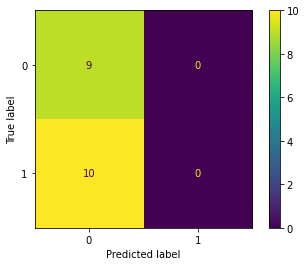

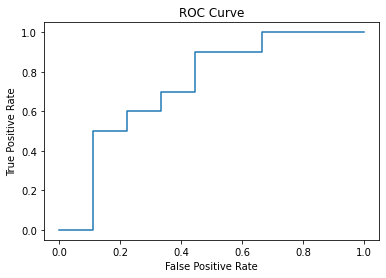

In [26]:
classifiers(tfidf_matrix_method_one, review_type_labels, 'svm')

##### Data Wrangling and Vectorization Method 4

Support Vector Machine Classifier
Accuracy =  47.4 %
F1 Score =  0.474
Precision =  0.0
Recall =  0.0
AUC =  0.656
 
Confusion Matrix


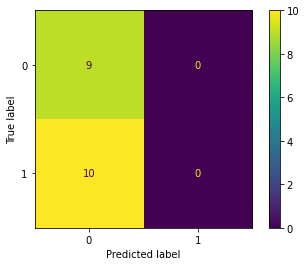

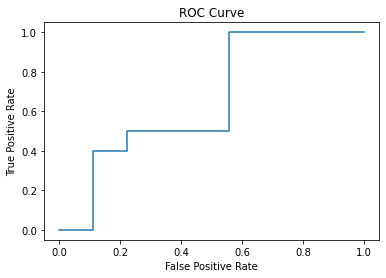

In [68]:
classifiers(tfidf_matrix_method_four, review_type_labels, 'svm')

## 3) Multi-Class Classification

Let's apply various classification algorithms to our corpus to determine whether Random Forest Classification, Naive Bayes Classification, or Support Vector Machine Classification perform well at predicting movie genre using movie review data.

### 3.1) Random Forest Classifier Experiments

Let's apply Random Forest Classification to our corpus to predict genre based on the movie review data.

##### Data Wrangling and Vectorization Method 1

Random Forest Classifier
Accuracy =  94.7 %
F1 Score =  0.947
 
Confusion Matrix


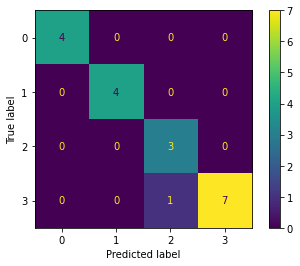

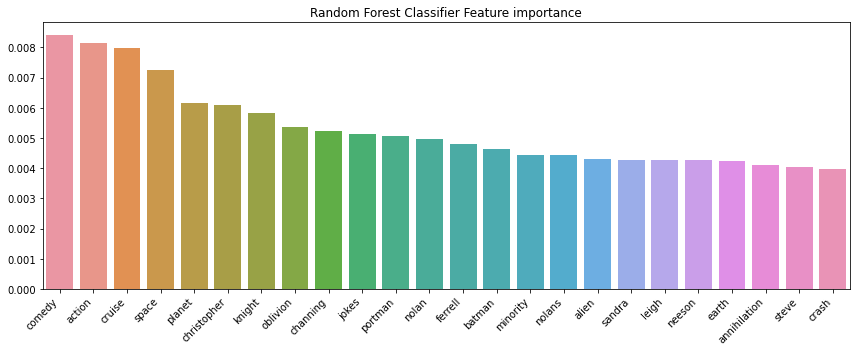

In [74]:
genre_labels = corpus_df['Genre of Movie']

classifiers(tfidf_matrix_method_one, genre_labels, 'randomforest')

##### Data Wrangling and Vectorization Method 4

Random Forest Classifier
Accuracy =  100.0 %
F1 Score =  1.0
 
Confusion Matrix


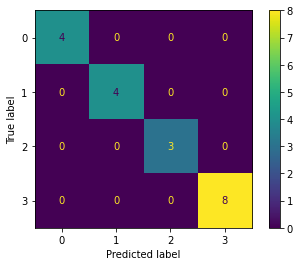

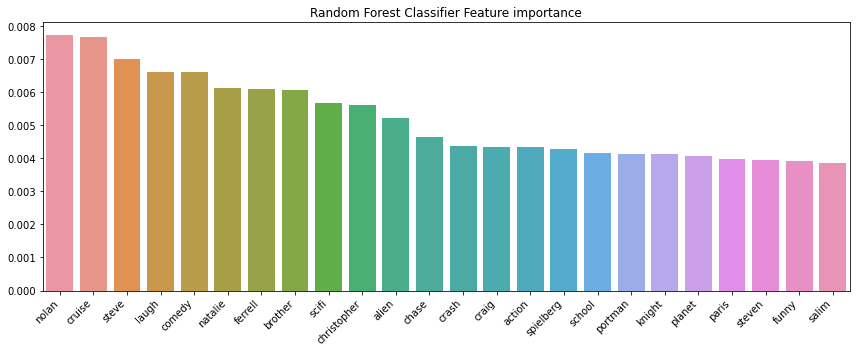

In [75]:
classifiers(tfidf_matrix_method_four, genre_labels, 'randomforest')

### 3.2) Naive Bayes Classifier Experiments

Let's apply Naive Bayes Classification to our corpus to examine how well we can predict movie genre based on the movie review.

##### Data Wrangling and Vectorization Method 1

Naive Bayes Classifier
Accuracy =  100.0 %
F1 Score =  1.0
 
Confusion Matrix


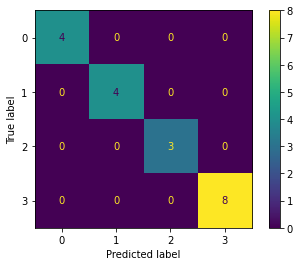

In [28]:
classifiers(tfidf_matrix_method_one, genre_labels, 'naive_bayes')

##### Data Wrangling and Vectorization Method 4

Naive Bayes Classifier
Accuracy =  100.0 %
F1 Score =  1.0
 
Confusion Matrix


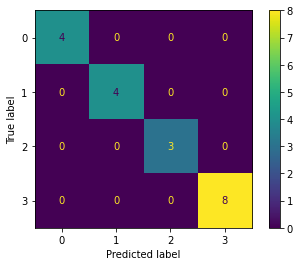

In [66]:
classifiers(tfidf_matrix_method_four, genre_labels, 'naive_bayes')

### 3.3) Support Vector Machine Experiments

Let's apply Support Vector Machine Classification to our corpus data to examine how well we can predict movie genre using the movie review data.

##### Data Wrangling and Vectorization Method 1

Support Vector Machine Classifier
Accuracy =  100.0 %
F1 Score =  1.0
 
Confusion Matrix


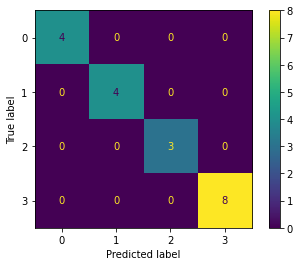

In [29]:
classifiers(tfidf_matrix_method_one, genre_labels, 'svm')

##### Data Wrangling and Vectorization Method 4

Support Vector Machine Classifier
Accuracy =  100.0 %
F1 Score =  1.0
 
Confusion Matrix


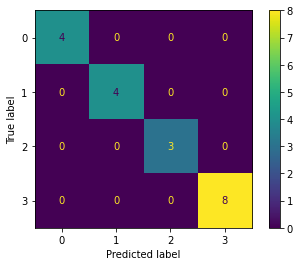

In [65]:
classifiers(tfidf_matrix_method_four, genre_labels, 'svm')

## 4) Topic Modeling

### 4.1) Latent Semantic Analysis Experiments

Let's implement latent semantic analysis to determine its effectiveness at topic modeling for our corpus of movie reviews.

In [30]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):

    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LSA model
    # train model
    lsamodel = LsiModel(doc_term_matrix
                        ,num_topics=number_of_topics
                        ,id2word = dictionary
                        ,power_iters=100)
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    index = similarities.MatrixSimilarity(lsamodel[doc_term_matrix])

    return lsamodel,dictionary,index
    

def lsa(tfidf_matrix, terms, n_components = 10):
    #this is a function to execute lsa.  inputs to the function include the tfidf matrix and
    #the desired number of components.
    
    LSA = TruncatedSVD(n_components=10)
    LSA.fit(tfidf_matrix)

    for i, comp in enumerate(LSA.components_):
        terms_comp = zip(terms, comp)
        sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
        print("Topic "+str(i)+": ")
        for t in sorted_terms:
            print(t[0])

    
def word2vec(processed_text, size = 100):
    #This is a function to generate the word2vec matrix. Input parameters include the 
    #tokenized text and matrix size
    
    #word to vec
    model_w2v = Word2Vec(processed_text, size=100, window=5, min_count=1, workers=4)

    #join all processed DSI words into single list
    processed_text_w2v=[]
    for i in processed_text:
        for k in i:
            processed_text_w2v.append(k)

    #obtian all the unique words from DSI
    w2v_words=list(set(processed_text_w2v))

    #can also use the get_feature_names() from TFIDF to get the list of words
    #w2v_words=Tfidf.get_feature_names()

    #empty dictionary to store words with vectors
    w2v_vectors={}

    #for loop to obtain weights for each word
    for i in w2v_words:
        temp_vec=model_w2v.wv[i]
        w2v_vectors[i]=temp_vec

    #create a final dataframe to view word vectors
    w2v_df=pd.DataFrame(w2v_vectors).transpose()
    print(w2v_df)
    return w2v_df


def plot_lsa(number_of_topics, words, processed_text):

    model,dictionary,index=create_gensim_lsa_model(processed_text,number_of_topics,words)

    for doc in processed_text:
        vec_bow = dictionary.doc2bow(doc)
        vec_lsi = model[vec_bow]  # convert the query to LSI space
        sims = index[vec_lsi] # perform a similarity query against the corpus

    fig, ax = plt.subplots(figsize=(30, 10))
    cax = ax.matshow(index, interpolation='nearest')
    ax.grid(True)
    plt.xticks(range(len(processed_text)), titles, rotation=90);
    plt.yticks(range(len(processed_text)), titles);
    fig.colorbar(cax)
    plt.show()
    return model


##### Data Wrangling and Vectorization Method 1

[(0, '-0.420*"movie" + -0.164*"films" + -0.164*"first" + -0.126*"would" + -0.125*"action" + -0.124*"story" + -0.122*"people" + -0.119*"horror" + -0.118*"movies" + -0.116*"characters"'), (1, '-0.462*"ahmed" + -0.397*"kinley" + -0.282*"covenant" + -0.242*"ritchie" + -0.219*"taliban" + -0.178*"gyllenhaal" + -0.143*"ritchies" + -0.133*"afghanistan" + -0.126*"interpreters" + -0.116*"interpreter"')]


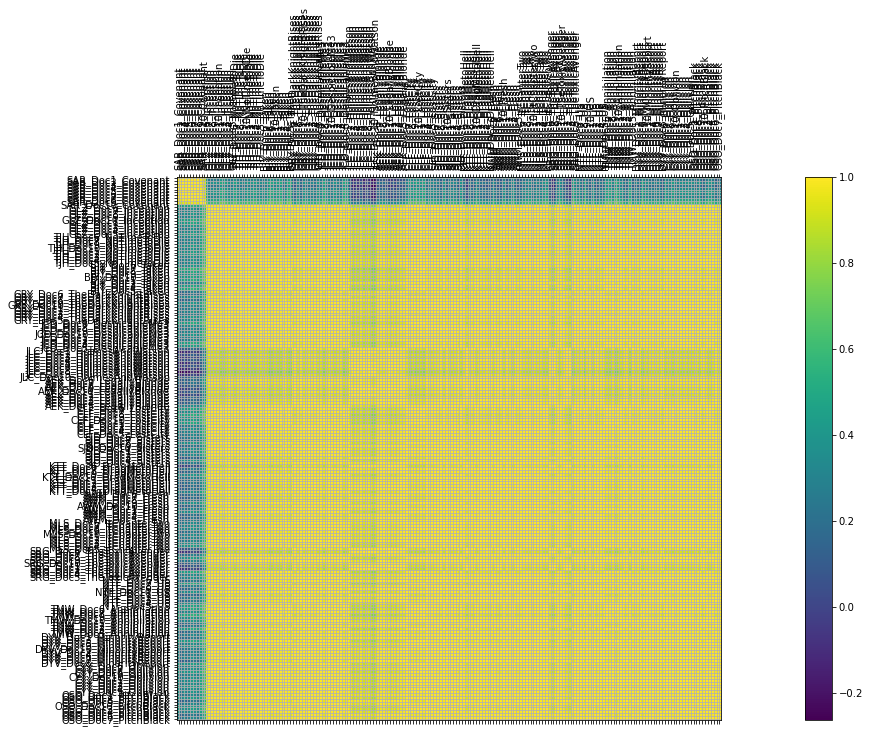

In [31]:
model_2concepts_10words=plot_lsa(2, 10, processed_text = processed_text_method_one)

[(0, '-0.420*"movie" + -0.164*"films" + -0.164*"first" + -0.126*"would" + -0.125*"action" + -0.124*"story" + -0.122*"people" + -0.119*"horror" + -0.118*"movies" + -0.116*"characters"'), (1, '0.462*"ahmed" + 0.397*"kinley" + 0.282*"covenant" + 0.242*"ritchie" + 0.219*"taliban" + 0.178*"gyllenhaal" + 0.143*"ritchies" + 0.133*"afghanistan" + 0.126*"interpreters" + 0.116*"interpreter"'), (2, '0.551*"toxic" + 0.344*"avenger" + 0.260*"melvin" + 0.202*"movie" + -0.189*"holmes" + 0.149*"waste" + 0.145*"troma" + -0.130*"watson" + 0.109*"tromaville" + 0.099*"movies"'), (3, '0.420*"holmes" + 0.287*"watson" + 0.195*"ferrell" + 0.184*"reilly" + -0.181*"knight" + 0.179*"comedy" + -0.151*"movie" + 0.146*"toxic" + -0.124*"nolan" + 0.111*"blonde"')]


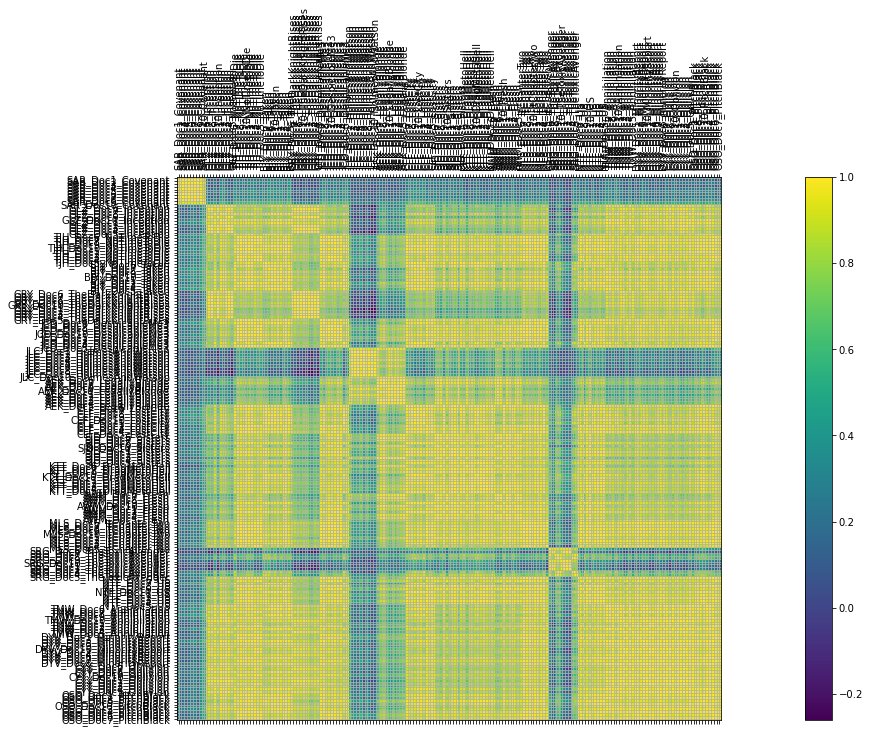

In [32]:
model_4concepts_10words=plot_lsa(4, 10, processed_text = processed_text_method_one)

[(0, '-0.420*"movie" + -0.164*"films" + -0.164*"first" + -0.126*"would" + -0.125*"action" + -0.124*"story" + -0.122*"people" + -0.119*"horror" + -0.118*"movies" + -0.116*"characters"'), (1, '0.462*"ahmed" + 0.397*"kinley" + 0.282*"covenant" + 0.242*"ritchie" + 0.219*"taliban" + 0.178*"gyllenhaal" + 0.143*"ritchies" + 0.133*"afghanistan" + 0.126*"interpreters" + 0.116*"interpreter"'), (2, '0.551*"toxic" + 0.344*"avenger" + 0.260*"melvin" + 0.202*"movie" + -0.189*"holmes" + 0.149*"waste" + 0.145*"troma" + -0.130*"watson" + 0.109*"tromaville" + 0.099*"movies"'), (3, '-0.420*"holmes" + -0.287*"watson" + -0.195*"ferrell" + -0.184*"reilly" + 0.181*"knight" + -0.179*"comedy" + 0.151*"movie" + -0.146*"toxic" + 0.124*"nolan" + -0.111*"blonde"'), (4, '0.280*"holmes" + -0.251*"blonde" + 0.234*"knight" + -0.196*"legally" + 0.193*"watson" + 0.140*"nolan" + -0.139*"school" + -0.138*"sisters" + 0.137*"batman" + -0.130*"movie"'), (5, '-0.427*"movie" + 0.341*"horror" + 0.182*"films" + -0.134*"sisters" 

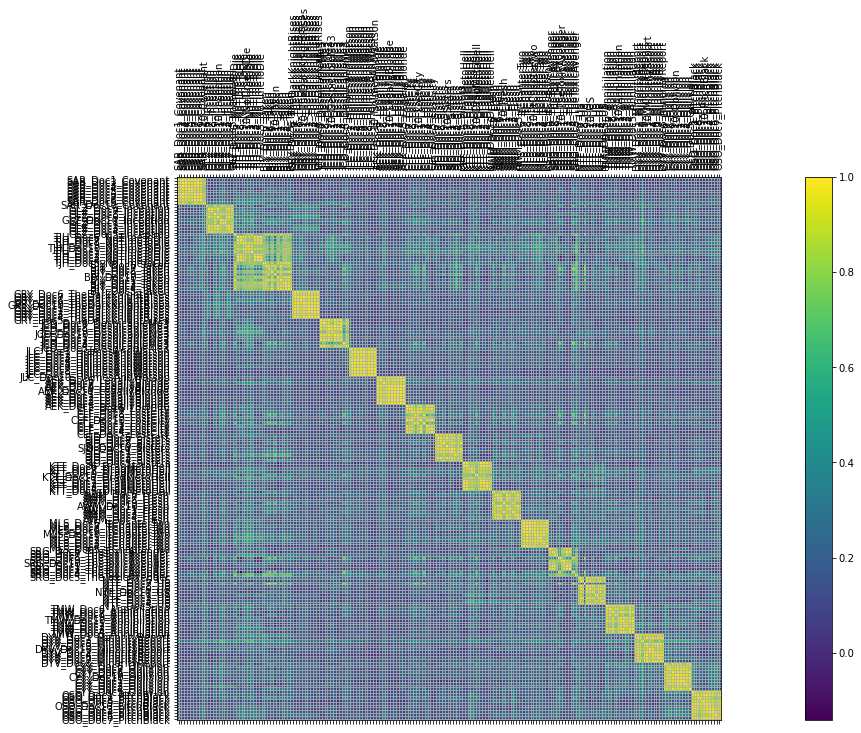

In [33]:
model_19concepts_10words=plot_lsa(19, 10, processed_text = processed_text_method_one)

In [34]:
topics = [2, 4, 19]
coherence_values = []
for t in topics:
    lsamodel,dictionary,index = create_gensim_lsa_model(processed_text_method_one,t,10)


    coherence_model_lsa = CoherenceModel(model=lsamodel,
                                         dictionary=dictionary, 
                                         texts=processed_text_method_one, 
                                         coherence='c_v')
    coherence_lsa = coherence_model_lsa.get_coherence()
    coherence_values.append(coherence_lsa)

    
coherence ={'2 concepts 10 words':coherence_values[0],
           '4 concepts 10 words': coherence_values[1],
           '19 concepts 10 words':coherence_values[2]}   

print(coherence)


[(0, '-0.420*"movie" + -0.164*"films" + -0.164*"first" + -0.126*"would" + -0.125*"action" + -0.124*"story" + -0.122*"people" + -0.119*"horror" + -0.118*"movies" + -0.116*"characters"'), (1, '-0.462*"ahmed" + -0.397*"kinley" + -0.282*"covenant" + -0.242*"ritchie" + -0.219*"taliban" + -0.178*"gyllenhaal" + -0.143*"ritchies" + -0.133*"afghanistan" + -0.126*"interpreters" + -0.116*"interpreter"')]
[(0, '-0.420*"movie" + -0.164*"films" + -0.164*"first" + -0.126*"would" + -0.125*"action" + -0.124*"story" + -0.122*"people" + -0.119*"horror" + -0.118*"movies" + -0.116*"characters"'), (1, '0.462*"ahmed" + 0.397*"kinley" + 0.282*"covenant" + 0.242*"ritchie" + 0.219*"taliban" + 0.178*"gyllenhaal" + 0.143*"ritchies" + 0.133*"afghanistan" + 0.126*"interpreters" + 0.116*"interpreter"'), (2, '-0.551*"toxic" + -0.344*"avenger" + -0.260*"melvin" + -0.202*"movie" + 0.189*"holmes" + -0.149*"waste" + -0.145*"troma" + 0.130*"watson" + -0.109*"tromaville" + -0.099*"movies"'), (3, '0.420*"holmes" + 0.287*"wa

##### Data Wrangling and Vectorization Method 4

[(0, '-0.237*"character" + -0.181*"first" + -0.154*"story" + -0.150*"people" + -0.149*"horror" + -0.126*"action" + -0.108*"doesnt" + -0.106*"year" + -0.106*"comedy" + -0.103*"dream"'), (1, '0.454*"ahmed" + 0.391*"kinley" + 0.276*"covenant" + 0.241*"ritchie" + 0.240*"interpreter" + 0.226*"taliban" + 0.177*"gyllenhaal" + 0.140*"ritchies" + 0.131*"afghanistan" + 0.115*"afghan"')]


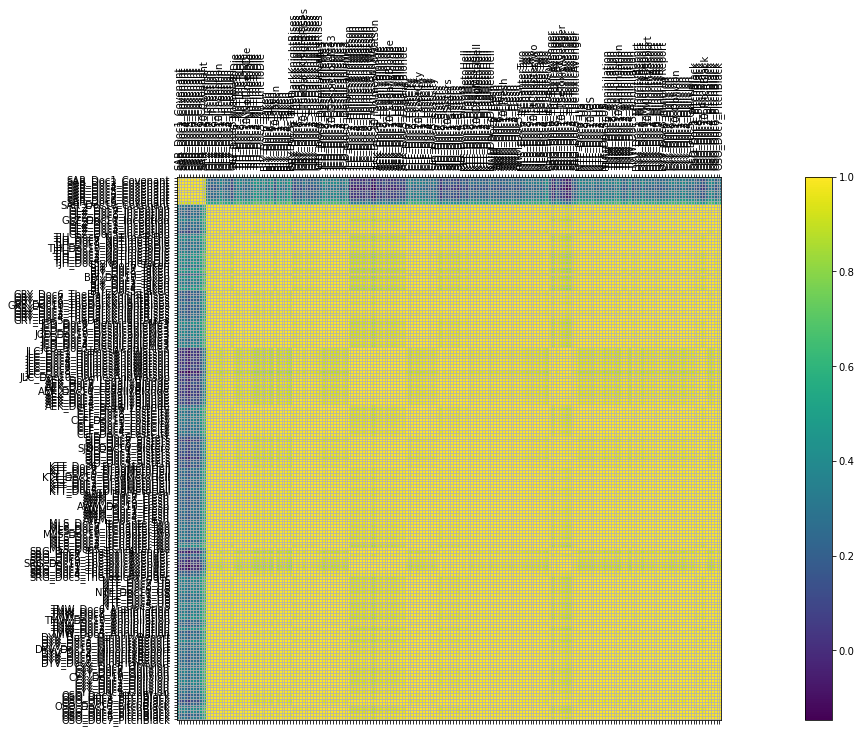

In [76]:
model_2concepts_10words=plot_lsa(2, 10, processed_text = processed_text_method_four)

[(0, '-0.237*"character" + -0.181*"first" + -0.154*"story" + -0.150*"people" + -0.149*"horror" + -0.126*"action" + -0.108*"doesnt" + -0.106*"year" + -0.106*"comedy" + -0.103*"dream"'), (1, '-0.454*"ahmed" + -0.391*"kinley" + -0.276*"covenant" + -0.241*"ritchie" + -0.240*"interpreter" + -0.226*"taliban" + -0.177*"gyllenhaal" + -0.140*"ritchies" + -0.131*"afghanistan" + -0.115*"afghan"'), (2, '-0.347*"dream" + 0.314*"toxic" + 0.216*"comedy" + 0.206*"holmes" + 0.197*"avenger" + -0.186*"knight" + -0.152*"nolan" + -0.143*"nolans" + 0.143*"melvin" + 0.143*"watson"'), (3, '0.474*"toxic" + -0.312*"holmes" + 0.303*"avenger" + 0.227*"melvin" + -0.219*"watson" + 0.166*"horror" + -0.141*"ferrell" + -0.138*"sister" + -0.133*"reilly" + 0.132*"waste"')]


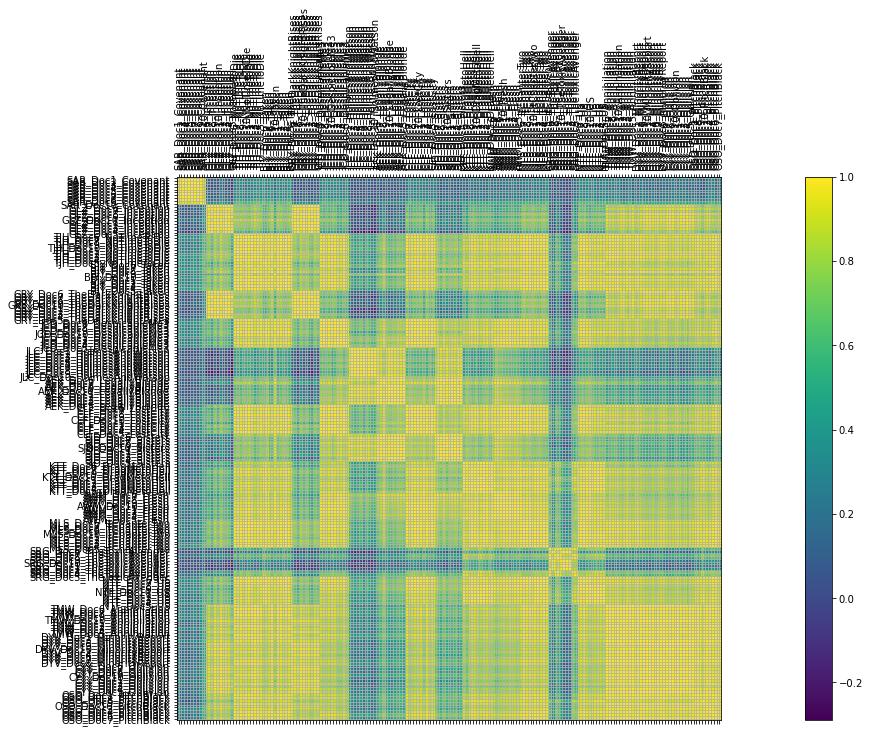

In [77]:
model_4concepts_10words=plot_lsa(4, 10, processed_text = processed_text_method_four)

[(0, '-0.237*"character" + -0.181*"first" + -0.154*"story" + -0.150*"people" + -0.149*"horror" + -0.126*"action" + -0.108*"doesnt" + -0.106*"year" + -0.106*"comedy" + -0.103*"dream"'), (1, '0.454*"ahmed" + 0.391*"kinley" + 0.276*"covenant" + 0.241*"ritchie" + 0.240*"interpreter" + 0.226*"taliban" + 0.177*"gyllenhaal" + 0.140*"ritchies" + 0.131*"afghanistan" + 0.115*"afghan"'), (2, '0.347*"dream" + -0.314*"toxic" + -0.216*"comedy" + -0.206*"holmes" + -0.197*"avenger" + 0.186*"knight" + 0.152*"nolan" + 0.143*"nolans" + -0.143*"melvin" + -0.143*"watson"'), (3, '0.474*"toxic" + -0.312*"holmes" + 0.303*"avenger" + 0.227*"melvin" + -0.219*"watson" + 0.166*"horror" + -0.141*"ferrell" + -0.138*"sister" + -0.133*"reilly" + 0.132*"waste"'), (4, '-0.406*"holmes" + -0.282*"watson" + -0.209*"dream" + -0.180*"ferrell" + -0.173*"reilly" + -0.172*"toxic" + -0.158*"knight" + 0.147*"blonde" + 0.128*"sister" + -0.117*"nolan"'), (5, '0.351*"blonde" + 0.260*"legally" + 0.245*"dream" + 0.190*"school" + 0.18

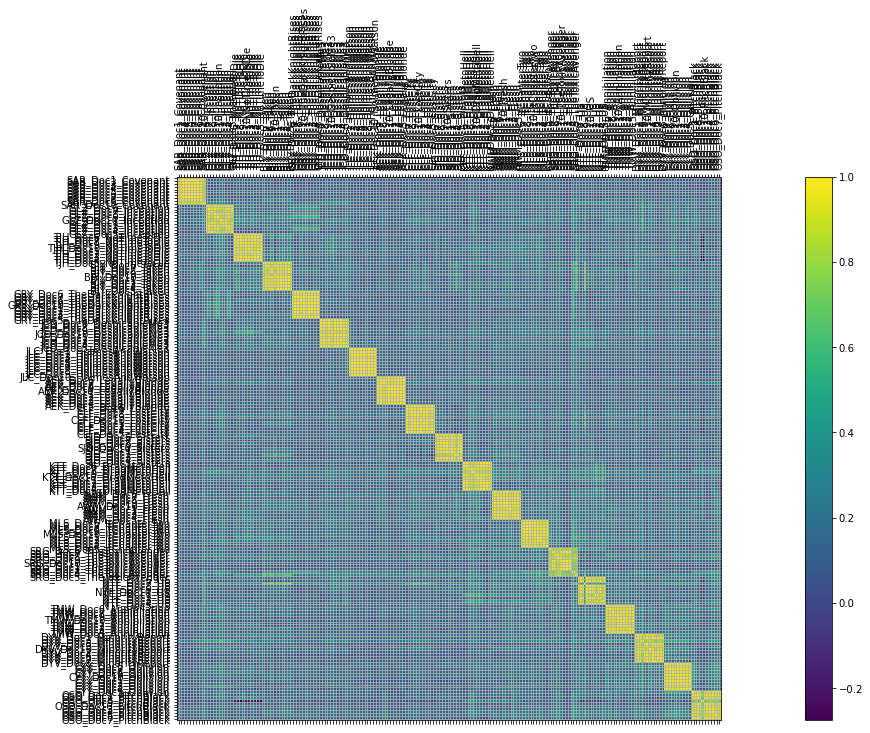

In [78]:
model_19concepts_10words=plot_lsa(19, 10, processed_text = processed_text_method_four)

In [79]:
topics = [2, 4, 19]
coherence_values = []

def lsa_coherence_function(processed_text, words):
    for t in topics:
        lsamodel, dictionary, index = create_gensim_lsa_model(processed_text, t, words)


        coherence_model_lsa = CoherenceModel(model=lsamodel,
                                             dictionary=dictionary, 
                                             texts=processed_text,
                                             coherence='c_v')
        coherence_lsa = coherence_model_lsa.get_coherence()
        coherence_values.append(coherence_lsa)


    coherence ={f'2 concepts and {words} 10 words':coherence_values[0],
               f'4 concepts and {words} words': coherence_values[1],
               f'19 concepts and {words} words':coherence_values[2]}   

    print(coherence)
    
lsa_coherence_function(processed_text = processed_text_method_four,
                   words = 10)


[(0, '-0.237*"character" + -0.181*"first" + -0.154*"story" + -0.150*"people" + -0.149*"horror" + -0.126*"action" + -0.108*"doesnt" + -0.106*"year" + -0.106*"comedy" + -0.103*"dream"'), (1, '-0.454*"ahmed" + -0.391*"kinley" + -0.276*"covenant" + -0.241*"ritchie" + -0.240*"interpreter" + -0.226*"taliban" + -0.177*"gyllenhaal" + -0.140*"ritchies" + -0.131*"afghanistan" + -0.115*"afghan"')]
[(0, '-0.237*"character" + -0.181*"first" + -0.154*"story" + -0.150*"people" + -0.149*"horror" + -0.126*"action" + -0.108*"doesnt" + -0.106*"year" + -0.106*"comedy" + -0.103*"dream"'), (1, '0.454*"ahmed" + 0.391*"kinley" + 0.276*"covenant" + 0.241*"ritchie" + 0.240*"interpreter" + 0.226*"taliban" + 0.177*"gyllenhaal" + 0.140*"ritchies" + 0.131*"afghanistan" + 0.115*"afghan"'), (2, '-0.347*"dream" + 0.314*"toxic" + 0.216*"comedy" + 0.206*"holmes" + 0.197*"avenger" + -0.186*"knight" + -0.152*"nolan" + -0.143*"nolans" + 0.143*"melvin" + 0.143*"watson"'), (3, '-0.474*"toxic" + 0.312*"holmes" + -0.303*"aveng

### 4.2) Latent Dirichlet Allocation Experiments

Let's implement latent dirichlet allocation models to determine their effectiveness at performing topic modeling on our corpus of movie reviews.

##### Data Wrangling and Vectorization Method 1

In [142]:
topic_word_list = []

def create_gensim_lda_model(doc_clean, number_of_topics, words):

    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    ldamodel = LdaModel(doc_term_matrix
                        ,num_topics=number_of_topics
                        ,id2word = dictionary
                        ,alpha='auto'
                        ,eta='auto'
                        ,iterations=100
                        ,random_state=23
                        ,passes=20)
    # train model
    print(ldamodel.print_topics(num_topics=number_of_topics, num_words=words))
    topic_word_tuples = ldamodel.print_topics(num_topics=number_of_topics, num_words=words)
    for i in topic_word_tuples:
        topic_word_list.append(i)
    index = similarities.MatrixSimilarity(ldamodel[doc_term_matrix])
    return ldamodel, dictionary, index, doc_term_matrix

#def lda(tfidf_matrix, terms, topics = 3, num_words = 10):
    #this is a function to perform lda on the tfidf matrix.  function varibales include:
    #tfidf matrix, desired number of topic, and number of words per topic.

#    topics = 3
#    num_words = 10
#    lda = LatentDirichletAllocation(n_components=topics).fit(tfidf_matrix)

#    topic_dict = {}
#    for topic_num, topic in enumerate(lda.components_):
#        topic_dict[topic_num] = " ".join([terms[i]for i in topic.argsort()[:-num_words - 1:-1]])

#    print(topic_dict)


In [36]:
######################################
#EXPERIMENT WITH THESE PARAMETERS
#number_of_topics=4
#words=20
#####################################

[(0, '0.003*"films" + 0.003*"blonde" + 0.002*"first" + 0.002*"people" + 0.002*"legally" + 0.002*"funny" + 0.002*"little" + 0.002*"still" + 0.002*"would" + 0.002*"horror"'), (1, '0.008*"movie" + 0.004*"first" + 0.004*"ahmed" + 0.004*"story" + 0.003*"holmes" + 0.003*"kinley" + 0.003*"would" + 0.003*"movies" + 0.003*"doesnt" + 0.003*"characters"'), (2, '0.007*"movie" + 0.003*"action" + 0.003*"films" + 0.003*"something" + 0.002*"horror" + 0.002*"character" + 0.002*"years" + 0.002*"first" + 0.002*"would" + 0.002*"story"'), (3, '0.007*"movie" + 0.004*"films" + 0.004*"knight" + 0.004*"horror" + 0.003*"first" + 0.003*"toxic" + 0.002*"batman" + 0.002*"black" + 0.002*"chapter" + 0.002*"years"')]


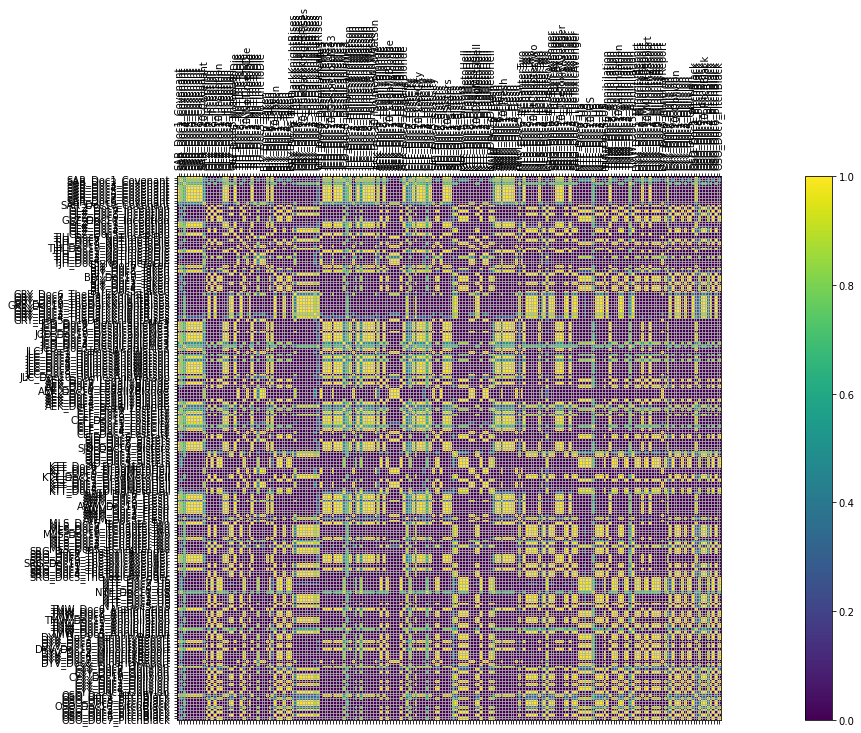

In [149]:
def run_lda(processed_text, number_of_topics, words):
    model2, dictionary2, index2, doctermmatrix2 = create_gensim_lda_model(processed_text, number_of_topics, words)

    for doc in processed_text:
        vec_bow2 = dictionary2.doc2bow(doc)
        vec2 = model2[vec_bow2]  # convert the query to embedded space
        sims2 = index2[vec2]  # perform a similarity query against the corpus
        #print(list(enumerate(sims2)))  

    fig, ax = plt.subplots(figsize=(30, 10))
    cax = ax.matshow(index2, interpolation='nearest')
    ax.grid(True)
    plt.xticks(range(len(processed_text)), titles, rotation=90);
    plt.yticks(range(len(processed_text)), titles);
    fig.colorbar(cax)
    plt.show()

run_lda(processed_text = processed_text_method_one, 
       number_of_topics = 4,
       words = 10)

In [150]:
topic_number_list = []
words_list = []
split_words_list = []
processed_words_list = []

    
def create_topics_words_df(number_of_topics, number_of_words):
    
    regex = re.compile('[^a-zA-Z]')

    for i in topic_word_list:
        topic_number_list.append(i[0])
        words_list.append(i[1])

    for j in words_list:
        split_words_list.append(j.split("+"))

    for k in split_words_list:
        for l in k:
            processed_words_list.append(regex.sub('', l))

    
    if number_of_topics == 2:
        topic_zero_words = processed_words_list[0: number_of_words]
        topic_one_words = processed_words_list[number_of_words : 2*number_of_words ]
        
        topic_words_df = pd.DataFrame(list(zip(topic_zero_words, 
                                              topic_one_words)),
               columns = ['Topic 0',
                          'Topic 1'])
    
        display(topic_words_df)
    
        
    elif number_of_topics == 4:
        topic_zero_words = processed_words_list[0: number_of_words]
        topic_one_words = processed_words_list[number_of_words : 2*number_of_words ]
        topic_two_words = processed_words_list[2*number_of_words: 3*number_of_words]
        topic_three_words = processed_words_list[3*number_of_words : 4*number_of_words ]
        
        topic_words_df = pd.DataFrame(list(zip(topic_zero_words, 
                                              topic_one_words,
                                              topic_two_words,
                                              topic_three_words)),
               columns = ['Topic 0', 
                         'Topic 1', 
                         'Topic 2',
                         'Topic 3'])
    
        display(topic_words_df)
        
    elif number_of_topics == 19:
        topic_zero_words = processed_words_list[0: number_of_words]
        topic_one_words = processed_words_list[number_of_words : 2*number_of_words ]
        topic_two_words = processed_words_list[2*number_of_words: 3*number_of_words]
        topic_three_words = processed_words_list[3*number_of_words : 4*number_of_words ]
        topic_four_words = processed_words_list[4* number_of_words : 5*number_of_words]
        topic_five_words = processed_words_list[5*number_of_words : 6*number_of_words ]
        topic_six_words = processed_words_list[6*number_of_words: 7*number_of_words]
        topic_seven_words = processed_words_list[7*number_of_words : 8*number_of_words ]
        topic_eight_words = processed_words_list[8*number_of_words: 9*number_of_words]
        topic_nine_words = processed_words_list[9*number_of_words : 10*number_of_words ]
        topic_ten_words = processed_words_list[10*number_of_words: 11*number_of_words]
        topic_eleven_words = processed_words_list[11*number_of_words : 12*number_of_words ]
        topic_twelve_words = processed_words_list[12*number_of_words: 13*number_of_words]
        topic_thirteen_words = processed_words_list[13*number_of_words : 14*number_of_words ]
        topic_fourteen_words = processed_words_list[14*number_of_words: 15*number_of_words]
        topic_fifteen_words = processed_words_list[15*number_of_words : 16*number_of_words ]
        topic_sixteen_words = processed_words_list[16*number_of_words : 17*number_of_words ]
        topic_seventeen_words = processed_words_list[17*number_of_words: 18*number_of_words]
        topic_eighteen_words = processed_words_list[18*number_of_words : 19*number_of_words ]
        
        topic_words_df = pd.DataFrame(list(zip(topic_zero_words, 
                                              topic_one_words,
                                              topic_two_words,
                                              topic_three_words,
                                              topic_four_words,
                                              topic_five_words,
                                              topic_six_words,
                                              topic_seven_words,
                                              topic_eight_words,
                                              topic_nine_words,
                                              topic_ten_words,
                                              topic_eleven_words,
                                              topic_twelve_words,
                                              topic_thirteen_words,
                                              topic_fourteen_words,
                                              topic_fifteen_words,
                                              topic_sixteen_words,
                                              topic_seventeen_words,
                                              topic_eighteen_words)),
               columns = ['Topic 0',
                         'Topic 1',
                         'Topic 2',
                         'Topic 3',
                         'Topic 4',
                         'Topic 5',
                         'Topic 6',
                         'Topic 7',
                         'Topic 8',
                         'Topic 9',
                         'Topic 10',
                         'Topic 11',
                         'Topic 12',
                         'Topic 13',
                         'Topic 14',
                         'Topic 15',
                         'Topic 16',
                         'Topic 17',
                         'Topic 18'])
    
        display(topic_words_df)
    
    

create_topics_words_df(number_of_topics = 4, number_of_words = 10)


Topic 0     Topic 1    Topic 2  Topic 3
0    films       movie      movie    movie
1   blonde       first     action    films
2    first       ahmed      films   knight
3   people       story  something   horror
4  legally      holmes     horror    first
5    funny      kinley  character    toxic
6   little       would      years   batman
7    still      movies      first    black
8    would      doesnt      would  chapter
9   horror  characters      story    years

In [151]:
topics = [2, 4, 19]
coherence_values = []

def lda_coherence_function(processed_text, words):
    for t in topics:
        ldamodel, dictionary, index, matrix = create_gensim_lda_model(processed_text, t, words)


        coherence_model_lda = CoherenceModel(model=ldamodel, 
                                             dictionary=dictionary, 
                                             texts=processed_text,
                                             coherence='c_v')
        coherence_lda = coherence_model_lda.get_coherence()
        coherence_values.append(coherence_lda)


    coherence ={f'2 topics and {words} words':coherence_values[0],
               f'4 topics and {words} words': coherence_values[1],
               f'19 topics and {words} words':coherence_values[2]}   

    print(coherence)
    
lda_coherence_function(processed_text = processed_text_method_one, words = 10)

[(0, '0.003*"movie" + 0.003*"films" + 0.002*"first" + 0.002*"blonde" + 0.002*"people" + 0.002*"years" + 0.002*"would" + 0.002*"horror" + 0.002*"character" + 0.002*"legally"'), (1, '0.008*"movie" + 0.003*"first" + 0.003*"films" + 0.003*"story" + 0.003*"movies" + 0.002*"would" + 0.002*"horror" + 0.002*"action" + 0.002*"characters" + 0.002*"people"')]
[(0, '0.003*"films" + 0.003*"blonde" + 0.002*"first" + 0.002*"people" + 0.002*"legally" + 0.002*"funny" + 0.002*"little" + 0.002*"still" + 0.002*"would" + 0.002*"horror"'), (1, '0.008*"movie" + 0.004*"first" + 0.004*"ahmed" + 0.004*"story" + 0.003*"holmes" + 0.003*"kinley" + 0.003*"would" + 0.003*"movies" + 0.003*"doesnt" + 0.003*"characters"'), (2, '0.007*"movie" + 0.003*"action" + 0.003*"films" + 0.003*"something" + 0.002*"horror" + 0.002*"character" + 0.002*"years" + 0.002*"first" + 0.002*"would" + 0.002*"story"'), (3, '0.007*"movie" + 0.004*"films" + 0.004*"knight" + 0.004*"horror" + 0.003*"first" + 0.003*"toxic" + 0.002*"batman" + 0.002

##### Data Wrangling and Vectorization Method 4

[(0, '0.007*"dream" + 0.007*"toxic" + 0.005*"character" + 0.004*"avenger" + 0.004*"melvin" + 0.003*"knight" + 0.003*"nolans" + 0.003*"people" + 0.003*"nolan" + 0.003*"inception"'), (1, '0.004*"horror" + 0.004*"character" + 0.004*"first" + 0.003*"story" + 0.003*"people" + 0.003*"doesnt" + 0.003*"family" + 0.003*"action" + 0.003*"director" + 0.002*"year"'), (2, '0.004*"despicable" + 0.004*"daughter" + 0.004*"character" + 0.004*"first" + 0.003*"minion" + 0.003*"story" + 0.003*"action" + 0.002*"minute" + 0.002*"three" + 0.002*"never"'), (3, '0.004*"blonde" + 0.003*"character" + 0.003*"first" + 0.003*"woman" + 0.003*"sister" + 0.003*"christine" + 0.003*"legally" + 0.002*"people" + 0.002*"something" + 0.002*"horror"')]


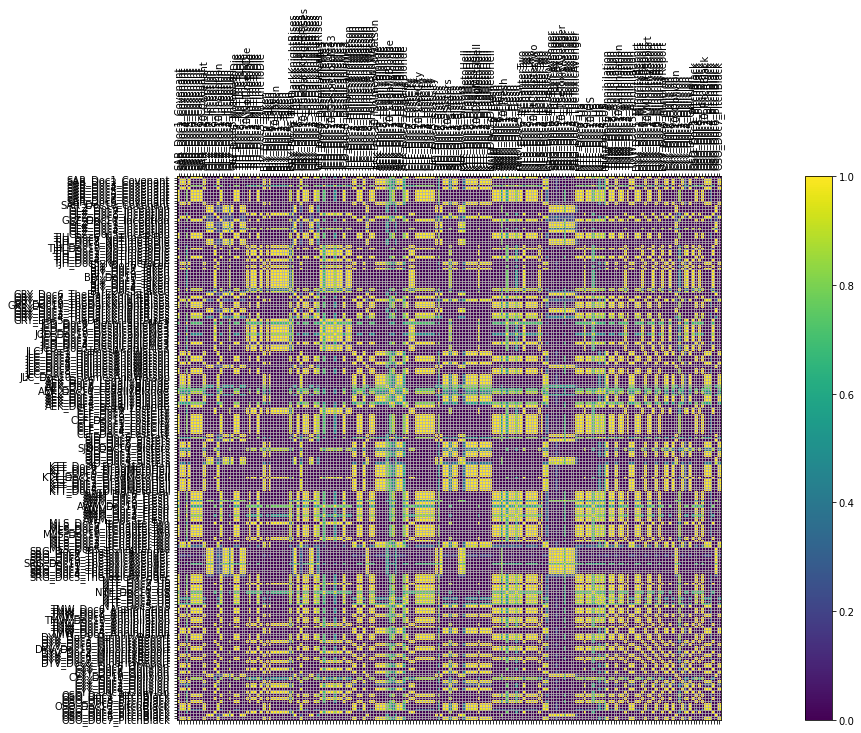

In [155]:
topic_word_list = []

run_lda(processed_text = processed_text_method_four, 
       number_of_topics = 4,
       words = 10)

In [156]:
topic_number_list = []
words_list = []
split_words_list = []
processed_words_list = []

create_topics_words_df(number_of_topics = 4, number_of_words = 10)


Topic 0    Topic 1     Topic 2    Topic 3
0      dream     horror  despicable     blonde
1      toxic  character    daughter  character
2  character      first   character      first
3    avenger      story       first      woman
4     melvin     people      minion     sister
5     knight     doesnt       story  christine
6     nolans     family      action    legally
7     people     action      minute     people
8      nolan   director       three  something
9  inception       year       never     horror

In [154]:
topics = [2, 4, 19]
coherence_values = []

lda_coherence_function(processed_text = processed_text_method_four, words = 10)

[(0, '0.004*"dream" + 0.004*"character" + 0.003*"toxic" + 0.003*"sister" + 0.003*"knight" + 0.002*"people" + 0.002*"nolan" + 0.002*"first" + 0.002*"poehler" + 0.002*"holmes"'), (1, '0.004*"character" + 0.004*"first" + 0.004*"horror" + 0.003*"story" + 0.003*"action" + 0.003*"people" + 0.002*"doesnt" + 0.002*"family" + 0.002*"woman" + 0.002*"director"')]
[(0, '0.007*"dream" + 0.007*"toxic" + 0.005*"character" + 0.004*"avenger" + 0.004*"melvin" + 0.003*"knight" + 0.003*"nolans" + 0.003*"people" + 0.003*"nolan" + 0.003*"inception"'), (1, '0.004*"horror" + 0.004*"character" + 0.004*"first" + 0.003*"story" + 0.003*"people" + 0.003*"doesnt" + 0.003*"family" + 0.003*"action" + 0.003*"director" + 0.002*"year"'), (2, '0.004*"despicable" + 0.004*"daughter" + 0.004*"character" + 0.004*"first" + 0.003*"minion" + 0.003*"story" + 0.003*"action" + 0.002*"minute" + 0.002*"three" + 0.002*"never"'), (3, '0.004*"blonde" + 0.003*"character" + 0.003*"first" + 0.003*"woman" + 0.003*"sister" + 0.003*"christin